# REQUEST

Investigar os dados em busca de insights que
possam ajudar a empresa a evitar evasões e também construir um modelo preditivo que possa
antecipar essas evasões, de modo que a empresa tenha tempo hábil para agir com ações de retenção.

- Elabore hipóteses e visualizações envolvendo a variável churn e, pelo menos, outras três
variáveis presentes no dataset;
- Desenvolva um modelo preditivo de classificação para identificar possíveis evasões e utilize
métricas adequadas para argumentar a efetividade do modelo;
- (BÔNUS) Qual o perfil de cliente que possui maior probabilidade de evasão?

# SOLUTION PLANNING

- 1. Load dataset and make a quick descriptive analysis to identify possible problems (missing values, outliers, balance of dataset);
- 2. Create Hypotesis and test them (insights);
- 3. Build a classification model (Decision Tree);
- 4. Evaluation of model performance;
- 5. Identify characteristcs of customers with highest probability to churn;
- 6. Business Results (Propose Scenarios).

# IMPORTS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn import ensemble as en
from sklearn import preprocessing as pp
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn import metrics
from sklearn import tree
from sklearn.dummy import DummyClassifier
import scikitplot as skplt

# HELPER FUNCTIONS

In [2]:
def graph_settings():
    sns.set_theme();
    plt.tight_layout();
    plt.rcParams['figure.figsize'] = [20, 10];
    sns.set();
graph_settings();

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - ( k-1 )*( r-1 )/( n-1 ) )
    
    kcorr = k - ( k-1 )**2/( n-1 )
    rcorr = r - ( r-1 )**2/( n-1 )
    
    return np.sqrt( ( chi2corr/n ) / ( min(kcorr-1, rcorr-1) ) )


def prevented_loss(conv_rate, precision, y_hat, model_name):
    result = {}
    # Defining cost and prevented loss
    cost = 20
    prevented_loss = 48

    # Model Cost
    cost_approach = y_hat.sum() * cost

    # Benefit - Precision
    benefit_approach = int((x_test.shape[0]*precision)*conv_rate)*prevented_loss

    profit = int(benefit_approach - cost_approach)
    
    result[model_name] = [conv_rate, profit]
    
    final_result = pd.DataFrame(result, index=['convertion_rate_%', 'prevented_loss'])
    
    
    return final_result.T

<Figure size 432x288 with 0 Axes>

# NOTEBOOK CONFIGURATION

In [5]:
# Show all rows and columns
pd.set_option('display.max_rows', df_raw.shape[0])
pd.set_option('display.max_columns', df_raw.shape[1])

# Suppress scientific Notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# LOADING DATASET

In [4]:
# Loading raw dataset
df_raw = pd.read_csv('../data/churn_challenge_data.csv', sep=",")

In [81]:
df_raw.head()

,Customer_ID,churn,HHstatin,actvsubs,adjmou,adjqty,adjrev,adults,area,asl_flag,attempt_Mean,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,avgmou,avgqty,avgrev,blck_dat_Mean,blck_vce_Mean,callfwdv_Mean,callwait_Mean,cc_mou_Mean,ccrndmou_Mean,change_mou,change_rev,comp_dat_Mean,comp_vce_Mean,complete_Mean,crclscod,creditcd,custcare_Mean,da_Mean,datovr_Mean,drop_blk_Mean,drop_dat_Mean,drop_vce_Mean,dualband,dwllsize,dwlltype,eqpdays,ethnic,forgntvl,hnd_price,hnd_webcap,income,infobase,inonemin_Mean,kid0_2,kid11_15,kid16_17,kid3_5,kid6_10,lor,marital,models,months,mou_Mean,mou_cdat_Mean,mou_cvce_Mean,mou_opkd_Mean,mou_opkv_Mean,mou_pead_Mean,mou_peav_Mean,mou_rvce_Mean,mouiwylisv_Mean,mouowylisv_Mean,new_cell,numbcars,opk_dat_Mean,opk_vce_Mean,ovrmou_Mean,ovrrev_Mean,ownrent,owylis_vce_Mean,peak_dat_Mean,peak_vce_Mean,phones,plcd_dat_Mean,plcd_vce_Mean,prizm_social_one,recv_sms_Mean,recv_vce_Mean,refurb_new,rev_Mean,roam_Mean,rv,threeway_Mean,totcalls,totmou,totmrc_Mean,totrev,truck,unan_dat_Mean,unan_vce_Mean,uniqsubs,vceovr_Mean
0,1000001,1,C,1,4085.00000,1602,1453.44000,1.00000,NORTHWEST/ROCKY MOUNTAIN AREA,N,52.33333,272,116,30,322.00000,136.00000,38.00000,83.37000,32.69000,29.66000,0.00000,0.66667,0.00000,0.33333,0.00000,0.00000,-157.25000,-18.99750,0.00000,45.00000,45.00000,A,Y,0.00000,0.24750,0.00000,1.33333,0.00000,0.66667,Y,A,S,361.00000,N,0.00000,149.98999,WCMB,4.00000,M,18.00000,U,U,U,U,U,15.00000,S,2.00000,61,219.25000,0.00000,90.64333,0.00000,55.22000,0.00000,132.60000,97.17667,0.00000,0.00000,U,3.00000,0.00000,24.00000,0.00000,0.00000,O,0.00000,0.00000,58.00000,2.00000,0.00000,52.33333,S,0.00000,42.33333,N,23.99750,0.00000,0.00000,0.00000,1652,4228.00000,22.50000,1504.62000,0.00000,0.00000,6.33333,2,0.00000
1,1000002,0,C,1,26367.00000,14624,2833.88000,1.00000,CHICAGO AREA,N,263.33333,305,158,40,477.00000,275.00000,48.00000,479.40000,265.89000,51.53000,0.00000,1.00000,0.00000,5.66667,5.46333,6.33333,532.25000,50.98750,0.00000,193.33333,193.33333,EA,Y,1.66667,0.24750,0.00000,9.33333,0.00000,8.33333,N,A,S,240.00000,Z,0.00000,NaN,WC,5.00000,M,53.00000,U,U,U,U,U,1.00000,S,6.00000,56,482.75000,0.00000,189.39667,0.00000,169.34333,0.00000,75.33333,55.28000,3.69667,24.21667,N,1.00000,0.00000,157.00000,22.75000,9.10000,NaN,46.33333,0.00000,83.66667,7.00000,0.00000,263.33333,U,0.00000,69.00000,N,57.49250,0.00000,1.00000,0.33333,14654,26400.00000,37.42500,2851.68000,1.00000,0.00000,61.33333,1,9.10000
2,1000003,1,C,1,24303.05000,7888,1934.47000,2.00000,GREAT LAKES AREA,N,9.00000,12,7,17,11.00000,6.00000,17.00000,433.98000,140.86000,34.54000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-4.25000,0.00000,0.00000,6.00000,6.00000,C,Y,0.00000,0.00000,0.00000,0.33333,0.00000,0.33333,N,A,S,1504.00000,N,0.00000,29.98999,NaN,5.00000,M,0.33333,U,U,U,Y,U,7.00000,M,1.00000,58,10.25000,0.00000,5.42667,0.00000,0.23333,0.00000,5.19333,0.00000,0.00000,0.00000,Y,2.00000,0.00000,1.00000,0.00000,0.00000,O,0.00000,0.00000,5.00000,2.00000,0.00000,9.00000,S,0.00000,0.33333,N,16.99000,0.00000,0.00000,0.00000,7903,24385.05333,16.99000,2155.91000,0.00000,0.00000,2.66667,1,0.00000
3,1000004,0,C,1,3035.00000,1479,1941.81000,4.00000,CHICAGO AREA,N,3.66667,8,3,38,50.00000,25.00000,40.00000,63.23000,30.81000,40.45000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-1.50000,0.00000,0.00000,3.66667,3.66667,B,Y,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,N,D,M,1812.00000,U,0.00000,29.98999,NaN,6.00000,M,1.33333,Y,U,U,U,U,6.00000,M,1.00000,60,7.50000,0.00000,8.41000,0.00000,5.45000,0.00000,3.38000,0.41333,0.00000,0.25667,Y,1.00000,0.00000,3.66667,0.00000,0.00000,NaN,0.33333,0.00000,1.33333,1.00000,0.00000,3.66667,T,0.00000,1.33333,N,38.00000,0.00000,0.00000,0.00000,1502,3065.00000,38.00000,2000.90000,0.00000,0.00000,0.00000,1,0.00000
4,1000005,0,C,1,13965.00000,4452,2166.48000,1.00000,NEW ENGLAND AREA,N,222.33333,558,191,55,586.00000,196.00000,80.00000,249.38000,79.50000,38.69000,0.00000,0.66667,0.00000,0.00000,11.07667,15.00000,38.50000,0.00000,0.00000,1

# DESCIPTIVE ANALYSIS OF THE DATASET

## Dataset Dimension

In [82]:
print(f'Number of rows: {df_raw.shape[0]}')
print(f'Number of columns: {df_raw.shape[1]}')

Number of rows: 100000
Number of columns: 99


## Data Type

In [7]:
# Show data types
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 99 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Customer_ID       100000 non-null  int64  
 1   churn             100000 non-null  int64  
 2   HHstatin          62077 non-null   object 
 3   actvsubs          100000 non-null  int64  
 4   adjmou            100000 non-null  float64
 5   adjqty            100000 non-null  int64  
 6   adjrev            100000 non-null  float64
 7   adults            76981 non-null   float64
 8   area              99960 non-null   object 
 9   asl_flag          100000 non-null  object 
 10  attempt_Mean      100000 non-null  float64
 11  avg3mou           100000 non-null  int64  
 12  avg3qty           100000 non-null  int64  
 13  avg3rev           100000 non-null  int64  
 14  avg6mou           97161 non-null   float64
 15  avg6qty           97161 non-null   float64
 16  avg6rev           971

## Check Missing Values

In [8]:
# Checking missing values
pd.DataFrame(df_raw.isna().sum().sort_values(ascending=False))

,0
numbcars,49366
dwllsize,38308
HHstatin,37923
ownrent,33706
dwlltype,31909
lor,30190
income,25436
adults,23019
infobase,22079
hnd_webcap,10189


- There are some variables with many missing values.
- I am going to solve this problem later

## Descriptive Statistics

In [10]:
# Separating Numerical Variables
num_variables = df_raw.select_dtypes(include=['float64', 'int64'])

# Separating Categorical Variables
cat_variables = df_raw.select_dtypes(include=['object'])

### Target Variable

In [70]:
df_raw['churn'].value_counts()

0    50438
1    49562
Name: churn, dtype: int64

The dataset is well balanced

### Numerical Variables

In [11]:
# Descriptive statistics
num_variables.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer_ID,100000.00000,1050000.50000,28867.65780,1000001.00000,1025000.75000,1050000.50000,1075000.25000,1100000.00000
churn,100000.00000,0.49562,0.49998,0.00000,0.00000,0.00000,1.00000,1.00000
actvsubs,100000.00000,1.35896,0.65555,0.00000,1.00000,1.00000,2.00000,53.00000
adjmou,100000.00000,7546.31470,8594.88973,0.00000,2474.00000,5102.50000,9661.00000,232855.10000
adjqty,100000.00000,2836.36692,3756.51388,0.00000,868.00000,1789.00000,3442.00000,98705.00000
adjrev,100000.00000,960.11153,840.17082,2.40000,452.18000,737.76000,1188.17500,27071.30000
adults,76981.00000,2.53033,1.45282,1.00000,1.00000,2.00000,3.00000,6.00000
attempt_Mean,100000.00000,145.75223,159.34809,0.00000,38.33333,101.00000,199.66667,2289.00000
avg3mou,100000.00000,519.64121,533.63407,0.00000,152.00000,358.00000,711.00000,7716.00000
avg3qty,100000.00000,180.33732,192.72583,0.00000,55.00000,125.00000,240.00000,3909.00000


### Categorical Variables

In [12]:
# Descriptive statistics
cat_variables.describe().T

,count,unique,top,freq
HHstatin,62077,6,C,39124
area,99960,19,NEW YORK CITY AREA,11098
asl_flag,100000,2,N,86064
crclscod,100000,54,AA,36509
creditcd,98268,2,Y,67234
dualband,99999,4,Y,72265
dwllsize,61692,15,A,47205
dwlltype,68091,2,S,48759
ethnic,98268,17,N,33389
hnd_webcap,89811,3,WCMB,75733


# HYPOTHESIS CREATION

## H1. Customers with higher ovrmou_Mean (>2.75) are more likely to churn

ovrmou_Mean = Mean overage minutes of use

**FALSE:** There are no big difference in churn rate

In [34]:
# Descriptive Statistics
pd.DataFrame(df_raw['ovrmou_Mean'].describe()).T

,count,mean,std,min,25%,50%,75%,max
ovrmou_Mean,99643.00000,41.07225,97.29615,0.00000,0.00000,2.75000,42.00000,4320.75000


In [35]:
# Check Missing Values
df_raw['ovrmou_Mean'].isna().sum()

357

- The variable has a big range (from 0 to 4,320)
- The mean and median are very different, indicating that there most be outliers and the distribution has a right tail
- There are 357 missing values

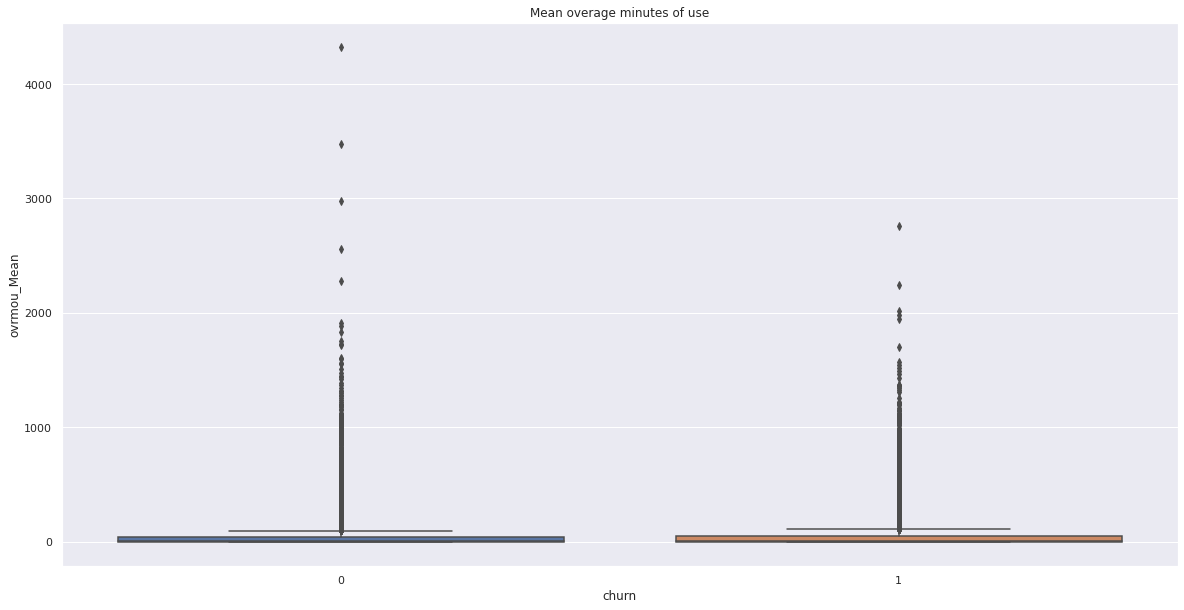

In [36]:
# Plotting Boxplot
sns.boxplot(data=df_raw, x='churn', y='ovrmou_Mean').set_title('Mean overage minutes of use');

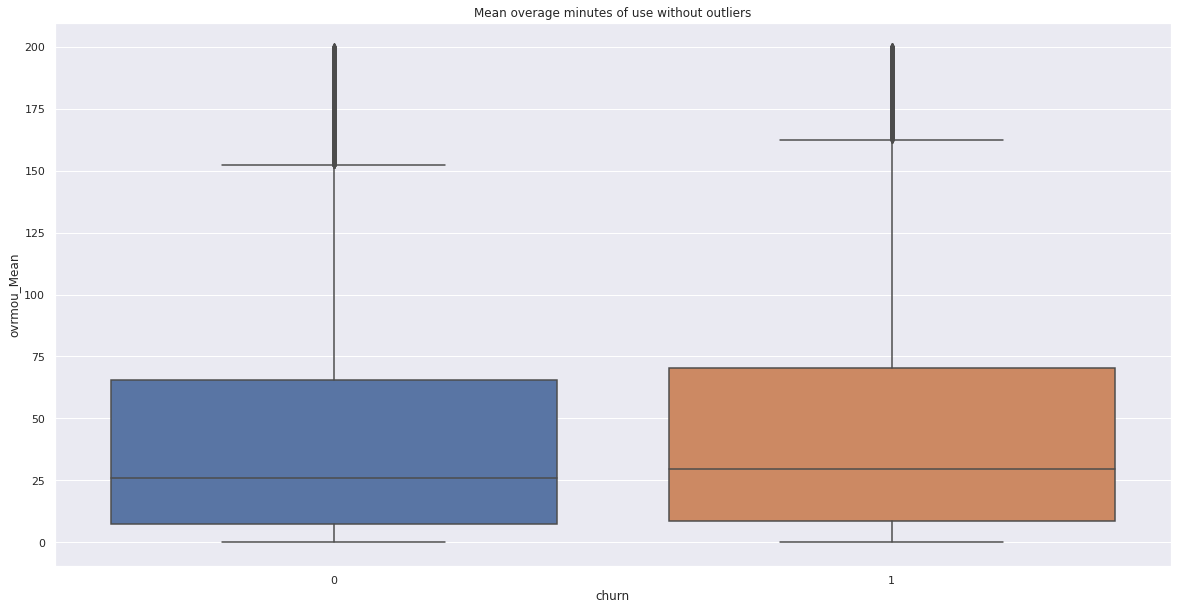

In [37]:
# Selecting ovrmou_Mean < 200 & != 0 to have a better visualization
auxh1 = df_raw[df_raw['ovrmou_Mean']<200]
auxh1 = auxh1[auxh1['ovrmou_Mean']!=0]

sns.boxplot(data=auxh1, x='churn', y='ovrmou_Mean').set_title('Mean overage minutes of use without outliers');

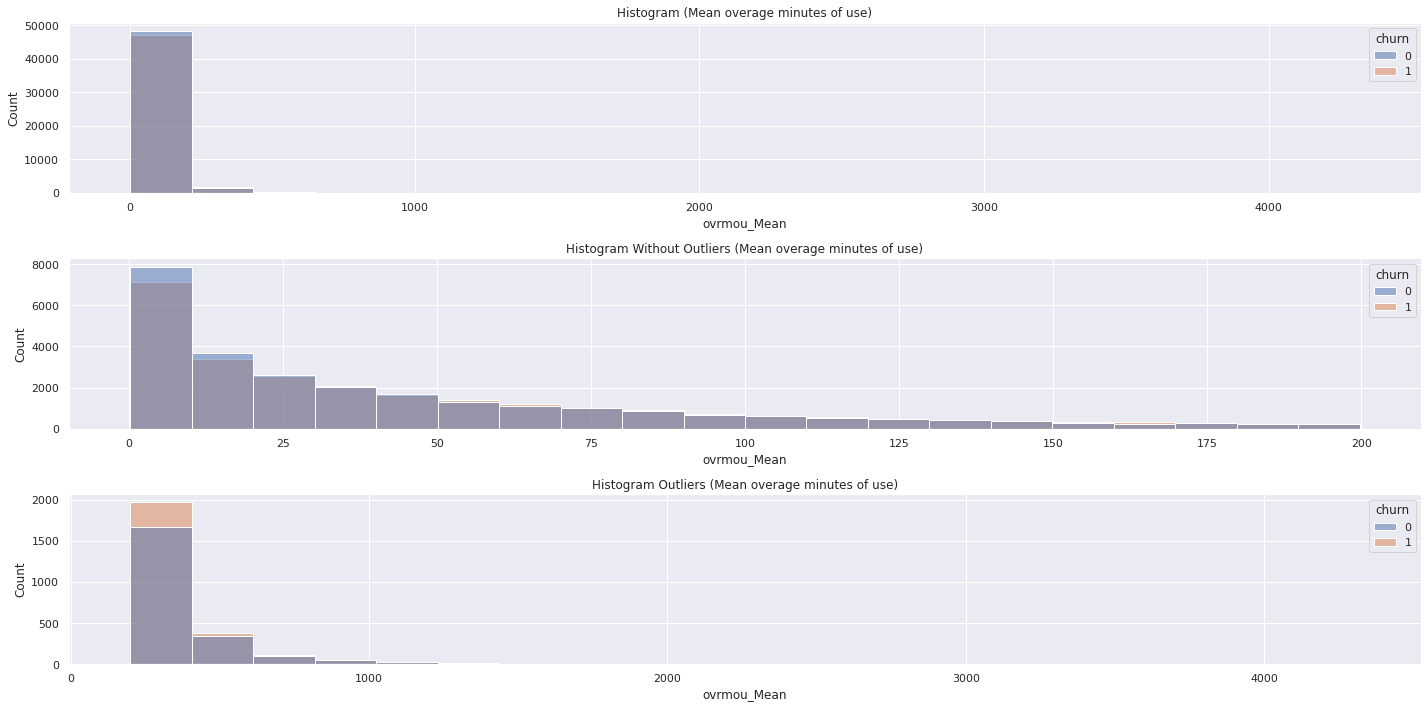

In [38]:
# Plotting Histogram with all data
plt.subplot(3,1,1)
sns.histplot(data=df_raw, x='ovrmou_Mean', hue='churn', bins=20).set_title('Histogram (Mean overage minutes of use)');

# Plotting Histogram without outliers
plt.subplot(3,1,2)
sns.histplot(data=auxh1, x='ovrmou_Mean', hue='churn', bins=20).set_title('Histogram Without Outliers (Mean overage minutes of use)');

plt.subplot(3,1,3)
aux2h1 = df_raw[df_raw['ovrmou_Mean']>=200]
sns.histplot(data=aux2h1, x='ovrmou_Mean', hue='churn', bins=20).set_title('Histogram Outliers (Mean overage minutes of use)');

plt.tight_layout()

In [39]:
# Separating dataset by ovrmou_Mean > 2.75 and <= 2.75 (2.75 = median)

ovrmou_Mean_hi = df_raw[df_raw['ovrmou_Mean']>2.75]
ovrmou_Mean_lo = df_raw[df_raw['ovrmou_Mean']<=2.75]

# percentage of churn == 1 for each dataset
perc_ovrmou_Mean_hi = round((ovrmou_Mean_hi['churn'] == 1).sum()/ovrmou_Mean_hi.shape[0], 3)*100
perc_ovrmou_Mean_lo = round((ovrmou_Mean_lo['churn'] == 1).sum()/ovrmou_Mean_lo.shape[0], 3)*100

print(f'{perc_ovrmou_Mean_hi}% of customers churned when mean overage revenue is higher than 2.75')
print(f'{perc_ovrmou_Mean_lo}% of customers churned when mean overage revenue is lower than 2.75')

50.3% of customers churned when mean overage revenue is higher than 2.75
48.6% of customers churned when mean overage revenue is lower than 2.75


In [40]:
# Separating dataset by ovrmou_Mean == 0 and != 0 

ovrmou_Mean_0 = df_raw[df_raw['ovrmou_Mean']==0]
ovrmou_Mean_1 = df_raw[df_raw['ovrmou_Mean']!=0]

# percentage of churn == 1 for each dataset
perc_ovrmou_Mean_0 = round((ovrmou_Mean_0['churn'] == 1).sum()/ovrmou_Mean_0.shape[0], 3)*100
perc_ovrmou_Mean_1 = round((ovrmou_Mean_1['churn'] == 1).sum()/ovrmou_Mean_1.shape[0], 3)*100

print(f'{perc_ovrmou_Mean_0}% of customers with no overage churned')
print(f'{perc_ovrmou_Mean_1}% of customers that have overaged their plan minutes churned')

49.0% of customers with no overage churned
50.0% of customers that have overaged their plan minutes churned


## H2. Customers with higher custcare_Mean (>1.79) are more likely to churn

custcare_Mean =  Mean number of customer care calls

**FALSE:** Customers with lower custcare_Mean are more likely to churn

In [41]:
# Descriptive Statistics
pd.DataFrame(df_raw['custcare_Mean'].describe()).T

,count,mean,std,min,25%,50%,75%,max
custcare_Mean,100000.00000,1.79084,5.31557,0.00000,0.00000,0.00000,1.66667,675.33333


In [42]:
# Check Missing Values
df_raw['custcare_Mean'].isna().sum()

0

- The median is 0, which means that half or more of the variable has value = 0
- Max value is 675
- The 3rd quantile is 1.66
- No missing  values

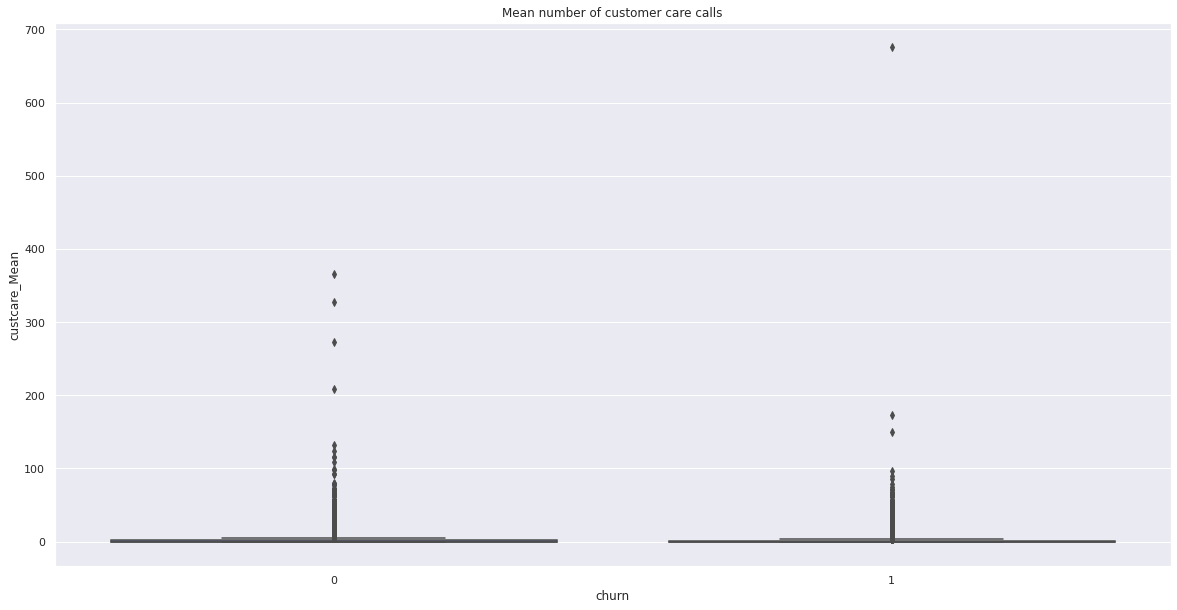

In [47]:
# Plotting Boxplot
sns.boxplot(data=df_raw, x='churn', y='custcare_Mean').set_title('Mean number of customer care calls');

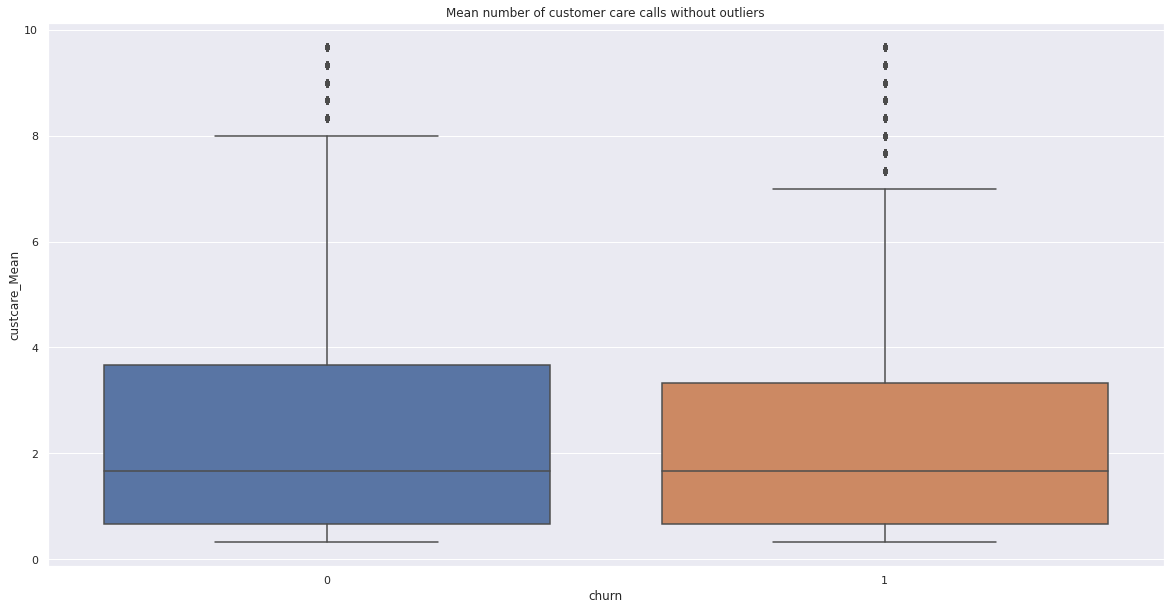

In [48]:
# Selecting custcare_Mean < 10 & != 0 to have a better visualization
auxh2 = df_raw[df_raw['custcare_Mean']<10]
auxh2 = auxh2[auxh2['custcare_Mean']!=0]

sns.boxplot(data=auxh2, x='churn', y='custcare_Mean').set_title('Mean number of customer care calls without outliers');

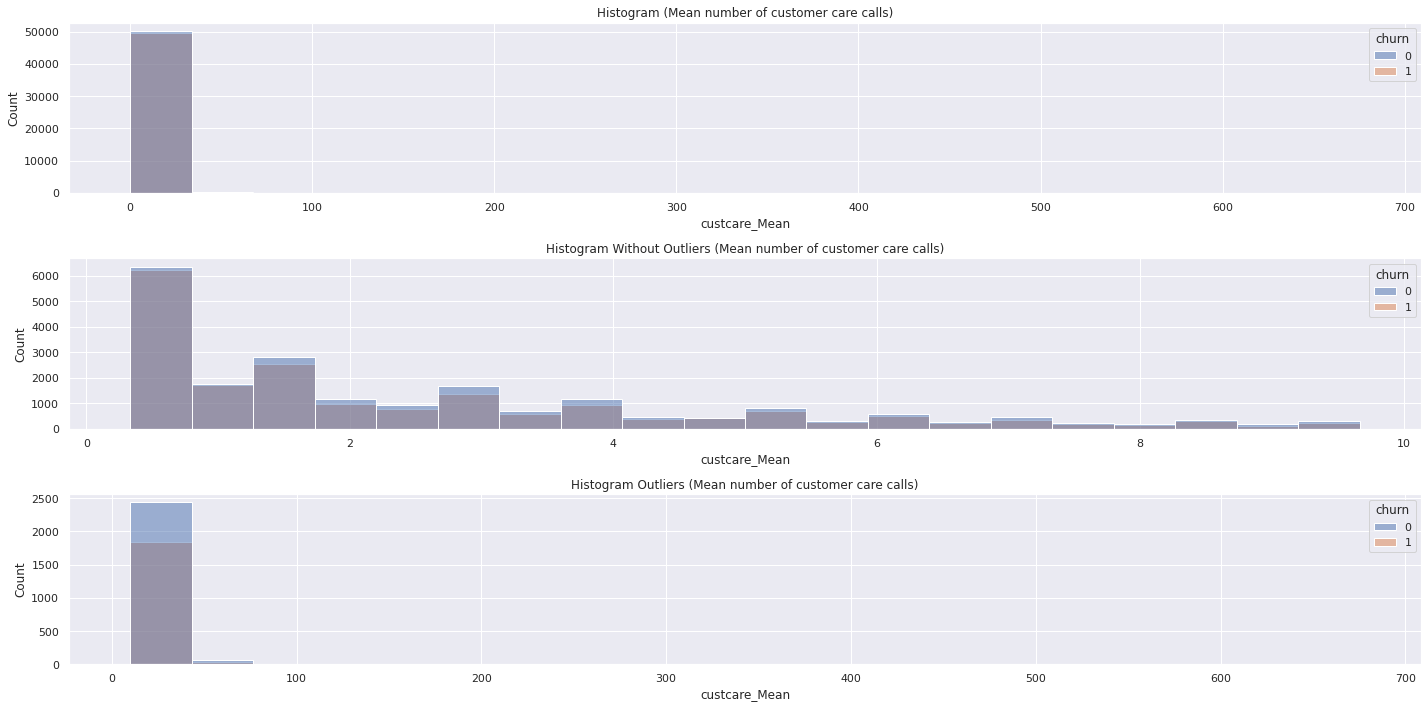

In [49]:
# Plotting Histogram with all data
plt.subplot(3,1,1)
sns.histplot(data=df_raw, x='custcare_Mean', hue='churn', bins=20).set_title('Histogram (Mean number of customer care calls)');

# Plotting Histogram without outliers
plt.subplot(3,1,2)
sns.histplot(data=auxh2, x='custcare_Mean', hue='churn', bins=20).set_title('Histogram Without Outliers (Mean number of customer care calls)');

plt.subplot(3,1,3)
aux2h2 = df_raw[df_raw['custcare_Mean']>=10]
sns.histplot(data=aux2h2, x='custcare_Mean', hue='churn', bins=20).set_title('Histogram Outliers (Mean number of customer care calls)');

plt.tight_layout()

In [50]:
# Separating dataset by custcare_Mean > 1.79 and <= 1.79 (1.79 = mean)

custcare_Mean_hi = df_raw[df_raw['custcare_Mean']>1.79]
custcare_Mean_lo = df_raw[df_raw['custcare_Mean']<=1.79]

# percentage of churn == 1 for each dataset
perc_custcare_Mean_hi = round((custcare_Mean_hi['churn'] == 1).sum()/custcare_Mean_hi.shape[0], 2)*100
perc_custcare_Mean_lo = round((custcare_Mean_lo['churn'] == 1).sum()/custcare_Mean_lo.shape[0], 3)*100

print(f'{perc_custcare_Mean_hi}% of customers churned when the mean number of calls to customer care is higher than 1.79')
print(f'{perc_custcare_Mean_lo}% of customers churned when the mean number of calls to customer care is lower than 1.79')

45.0% of customers churned when the mean number of calls to customer care is higher than 1.79
51.0% of customers churned when the mean number of calls to customer care is lower than 1.79


In [51]:
# Separating dataset by custcare_Mean == 0 and != 0 

custcare_Mean_0 = df_raw[df_raw['custcare_Mean']==0]
custcare_Mean_1 = df_raw[df_raw['custcare_Mean']!=0]

# percentage of churn == 1 for each dataset
perc_custcare_Mean_0 = round((custcare_Mean_0['churn'] == 1).sum()/custcare_Mean_0.shape[0], 2)*100
perc_custcare_Mean_1 = round((custcare_Mean_1['churn'] == 1).sum()/custcare_Mean_1.shape[0], 2)*100

print(f'{perc_custcare_Mean_0}% of customers churned when the mean number of calls to customer care is = 0')
print(f'{perc_custcare_Mean_1}% of customers churned when the mean number of calls to customer care is > 0')

52.0% of customers churned when the mean number of calls to customer care is = 0
47.0% of customers churned when the mean number of calls to customer care is > 0


## H3. Customers with higher change_mou (> -6.25) are more likely to churn

change_mou = Percentage change in monthly minutes of use vs previous three month average

**FALSE:** Customers with lower change_mou are more likely to churn

In [52]:
# Descriptive Statistics
pd.DataFrame(df_raw['change_mou'].describe()).T

,count,mean,std,min,25%,50%,75%,max
change_mou,99109.00000,-13.93382,276.08751,-3875.00000,-87.00000,-6.25000,63.00000,31219.25000


In [53]:
# Checking Missing Values
df_raw['change_mou'].isna().sum()

891

- The standard deviation is 276.08 and mean -13.93, which means that the data has high variance
- Mean and midian is not that different, the distribution might be normal
- There are 891 missing values
- The max values is a bit strange (31,219% of change)

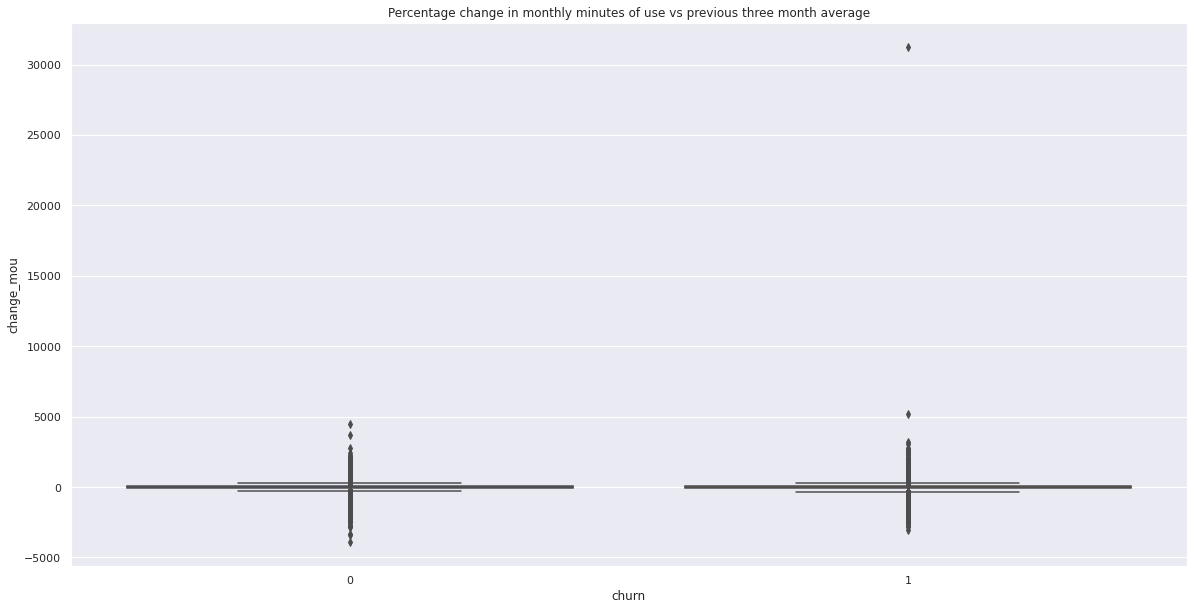

In [55]:
# Plotting Boxplot
sns.boxplot(data=df_raw, x='churn', y='change_mou').set_title('Percentage change in monthly minutes of use vs previous three month average');

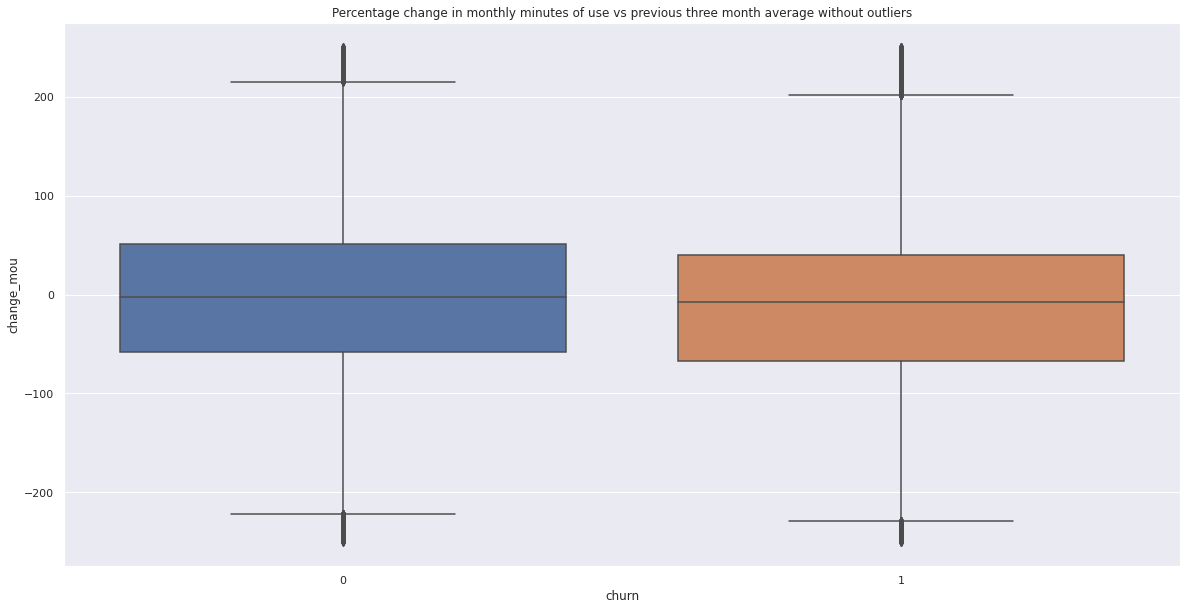

In [56]:
# Selecting change_mou < 250 & > -250 to have a better visualization
auxh3 = df_raw[df_raw['change_mou']<250]
auxh3 = auxh3[auxh3['change_mou']>-250]

sns.boxplot(data=auxh3, x='churn', y='change_mou').set_title('Percentage change in monthly minutes of use vs previous three month average without outliers');

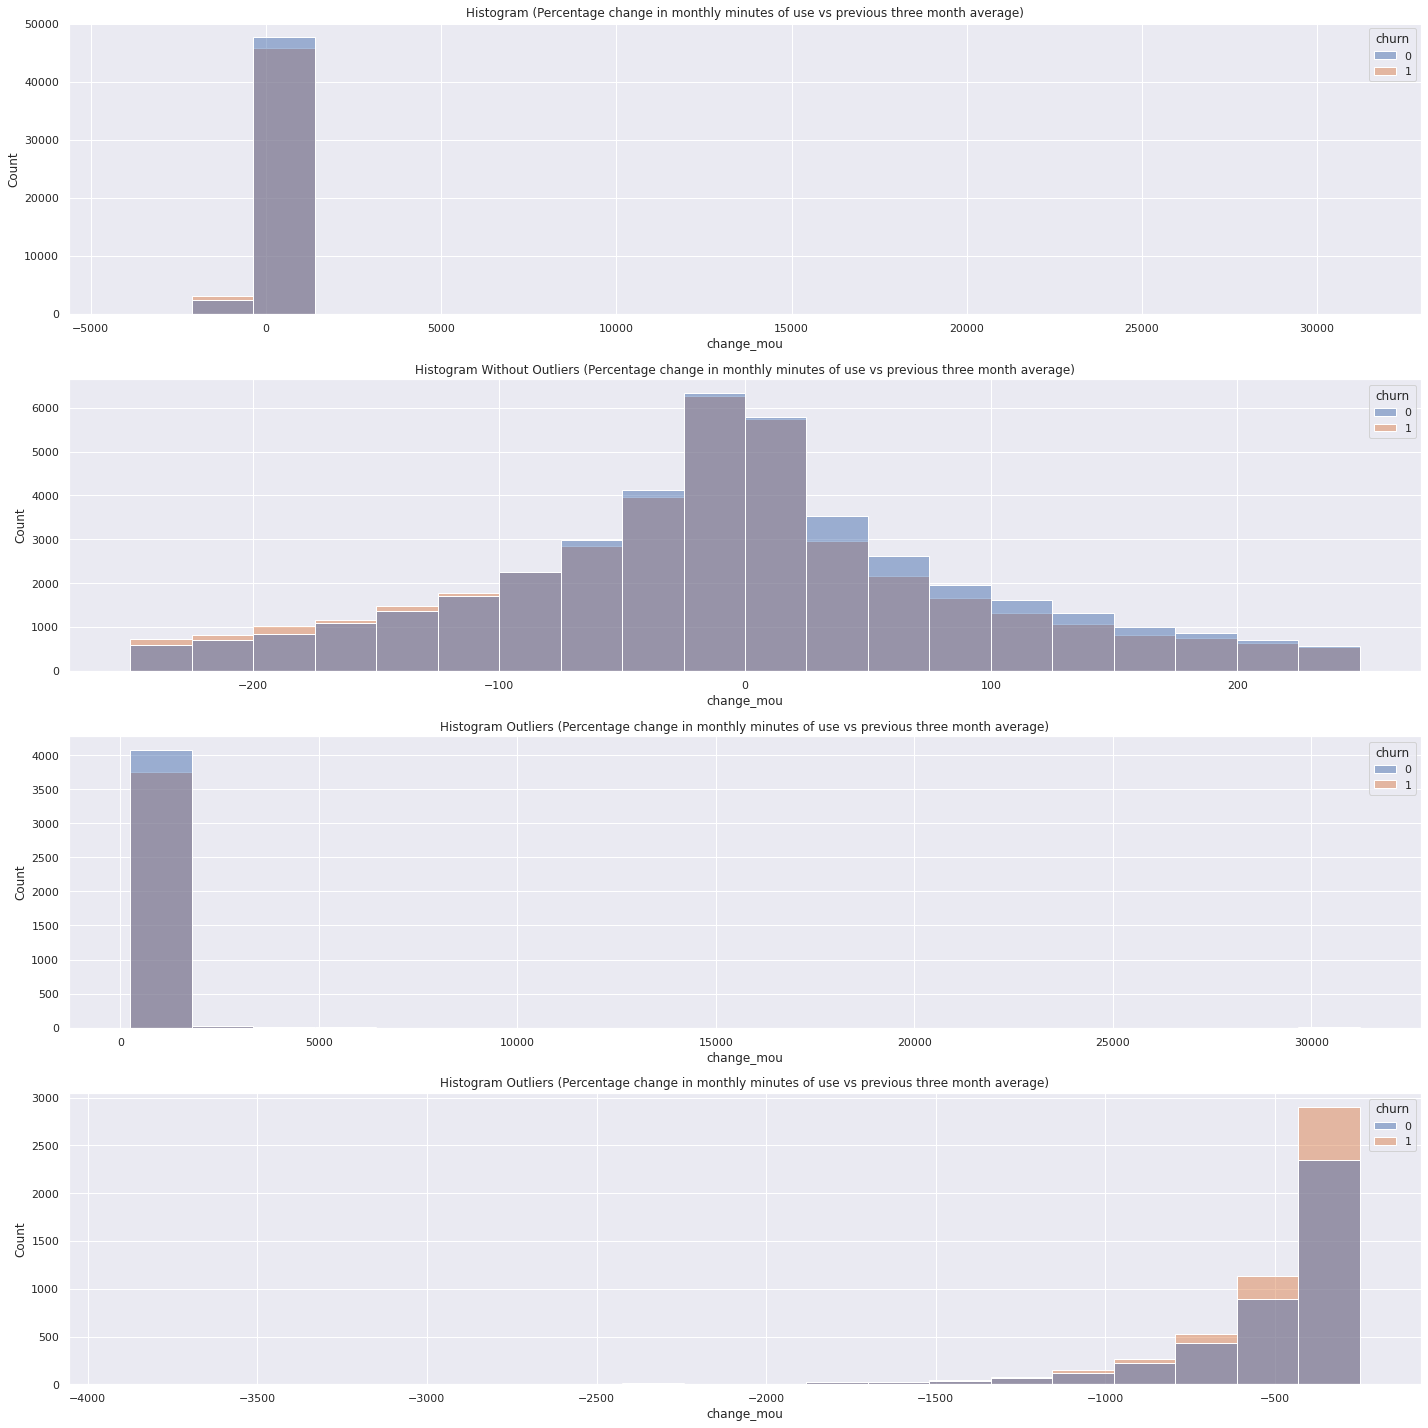

In [57]:
plt.figure(figsize=(20,20))

# Plotting Histogram with all data
plt.subplot(4,1,1)
sns.histplot(data=df_raw, x='change_mou', hue='churn', bins=20).set_title('Histogram (Percentage change in monthly minutes of use vs previous three month average)');

# Plotting Histogram without outliers
plt.subplot(4,1,2)
sns.histplot(data=auxh3, x='change_mou', hue='churn', bins=20).set_title('Histogram Without Outliers (Percentage change in monthly minutes of use vs previous three month average)');

plt.subplot(4,1,3)
aux2h3 = df_raw[df_raw['change_mou']>=250]
sns.histplot(data=aux2h3, x='change_mou', hue='churn', bins=20).set_title('Histogram Outliers (Percentage change in monthly minutes of use vs previous three month average)');

plt.subplot(4,1,4)
aux3h3 = df_raw[df_raw['change_mou']<=-250]
sns.histplot(data=aux3h3, x='change_mou', hue='churn', bins=20).set_title('Histogram Outliers (Percentage change in monthly minutes of use vs previous three month average)');

plt.tight_layout()

In [58]:
# Separating dataset by change_mou > -6.25 and <= -6.25 (-6.25 = median)

change_mou_hi = df_raw[df_raw['change_mou']>-6.25]
change_mou_lo = df_raw[df_raw['change_mou']<=-6.25]

# percentage of churn == 1 for each dataset
perc_change_mou_hi = round((change_mou_hi['churn'] == 1).sum()/change_mou_hi.shape[0], 2)*100
perc_change_mou_lo = round((change_mou_lo['churn'] == 1).sum()/change_mou_lo.shape[0], 3)*100

print(f'{perc_change_mou_hi}% of customers churned when the change of minutes use was higher then -6.25%')
print(f'{perc_change_mou_lo}% of customers churned when the change of minutes use was lower then -6.25%')

47.0% of customers churned when the change of minutes use was higher then -6.25%
51.4% of customers churned when the change of minutes use was lower then -6.25%


In [59]:
# Separating dataset by change_mou > 0 and <= 0

change_mou_pos = df_raw[df_raw['change_mou']>0]
change_mou_neg = df_raw[df_raw['change_mou']<=0]

# percentage of churn == 1 for each dataset
perc_change_mou_pos = round((change_mou_pos['churn'] == 1).sum()/change_mou_pos.shape[0], 2)*100
perc_change_mou_neg = round((change_mou_neg['churn'] == 1).sum()/change_mou_neg.shape[0], 3)*100

print(f'{perc_change_mou_pos}% of customers churned when they stated using more minutes')
print(f'{perc_change_mou_neg}% of customers churned when they stated using less minutes')

46.0% of customers churned when they stated using more minutes
51.9% of customers churned when they stated using less minutes


## H4. Customer that lives in area with fewer customers are more likely to churn

area = Geographic area

**PARTIALLY TRUE:** Of the 5 areas with fewer customers, NORTHWEST/ROCKY MOUNTAIN AREA and SOUTH FLORIDA AREA are the top 2 with highest churn rate

In [60]:
# Descriptive Statistics
pd.DataFrame(df_raw['area'].describe()).T

,count,unique,top,freq
area,99960,19,NEW YORK CITY AREA,11098


In [61]:
# Check Missing Values
na = df_raw['area'].isna().sum()
print(f'There are {na} missing values')

There are 40 missing values


In [62]:
# Number of customers by area
df_raw['area'].value_counts()

NEW YORK CITY AREA               11098
LOS ANGELES AREA                  6636
DC/MARYLAND/VIRGINIA AREA         6567
MIDWEST AREA                      6346
SOUTHWEST AREA                    6187
ATLANTIC SOUTH AREA               6132
CALIFORNIA NORTH AREA             5913
NEW ENGLAND AREA                  5452
DALLAS AREA                       5426
CHICAGO AREA                      5141
GREAT LAKES AREA                  4649
OHIO AREA                         4580
NORTH FLORIDA AREA                4350
HOUSTON AREA                      4341
NORTHWEST/ROCKY MOUNTAIN AREA     4328
CENTRAL/SOUTH TEXAS AREA          4299
SOUTH FLORIDA AREA                3332
TENNESSEE AREA                    2737
PHILADELPHIA AREA                 2446
Name: area, dtype: int64

In [63]:
# Cross tabulation
pd.crosstab(df_raw['area'], df_raw['churn']).apply(lambda x: x / x.sum(), axis=1).sort_values(ascending = False, by=[1])

churn,0,1
area,,
NORTHWEST/ROCKY MOUNTAIN AREA,0.43091,0.56909
SOUTH FLORIDA AREA,0.46639,0.53361
CALIFORNIA NORTH AREA,0.47894,0.52106
NORTH FLORIDA AREA,0.48000,0.52000
NEW ENGLAND AREA,0.48258,0.51742
SOUTHWEST AREA,0.48990,0.51010
PHILADELPHIA AREA,0.49346,0.50654
NEW YORK CITY AREA,0.49973,0.50027
LOS ANGELES AREA,0.50181,0.49819


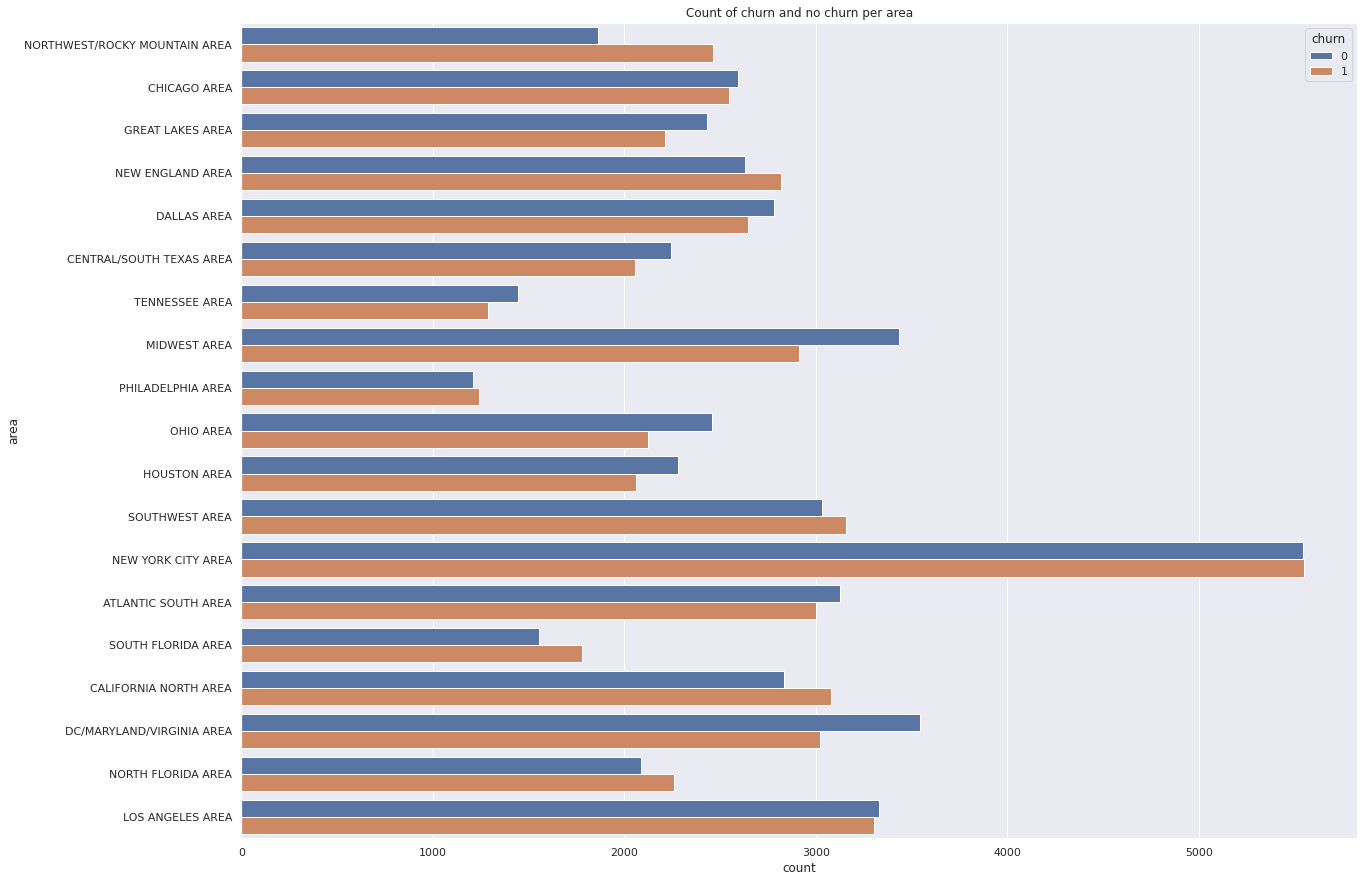

In [64]:
plt.figure(figsize=(20,15))

# Plotting Boxplot
sns.countplot(data=df_raw, y='area', hue='churn').set_title('Count of churn and no churn per area');

In [65]:
# Measuring Association with Cramer V
h4_cramerv = cramer_v(df_raw['area'], df_raw['churn'])
print(f'Cramer V: {round(h4_cramerv, 4)}')
print('Their association is weak')

Cramer V: 0.0519
Their association is weak


## H5. Customers with lower mou_Mean (> 355.5) are more likely to churn

mou_Mean = Mean number of monthly minutes of use

**TRUE:** Customers with lower monthly average use of minutes has higher churn rate

In [66]:
# Descriptive Statistics
pd.DataFrame(df_raw['mou_Mean'].describe()).T

,count,mean,std,min,25%,50%,75%,max
mou_Mean,99643.00000,513.55994,525.16814,0.00000,150.75000,355.50000,703.00000,12206.75000


In [67]:
# Checking Missing Values
df_raw['mou_Mean'].isna().sum()

357

- There are customers with 0 minutes of use
- There area customers with monthly average use of 12,206 minutes
- There area 357 missing values

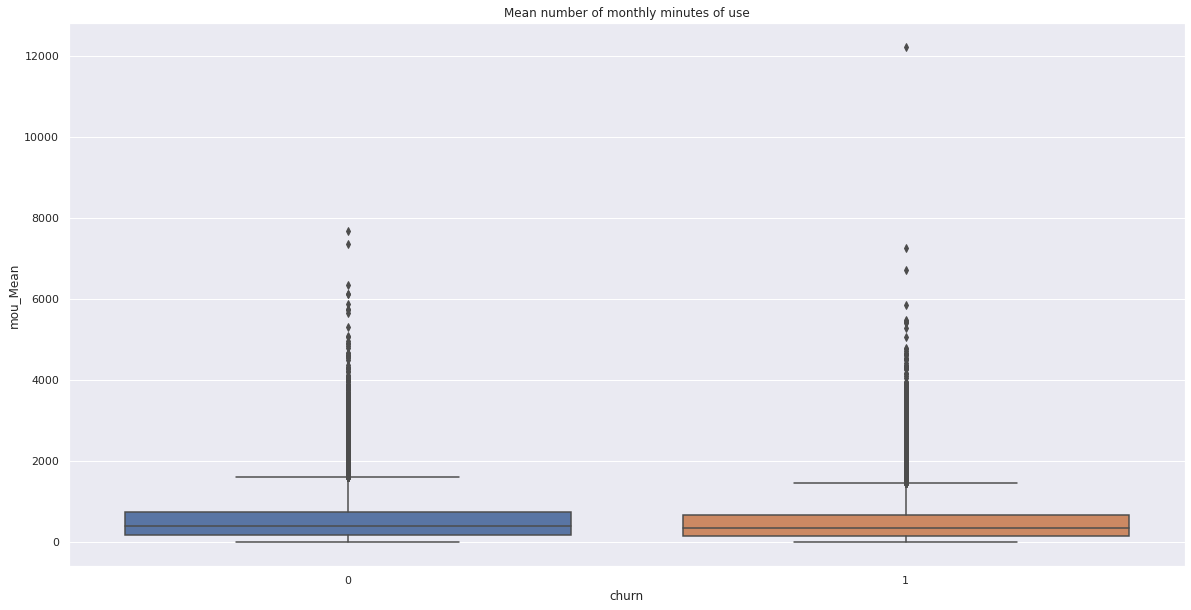

In [68]:
# Plotting Boxplot
sns.boxplot(data=df_raw, x='churn', y='mou_Mean').set_title('Mean number of monthly minutes of use');

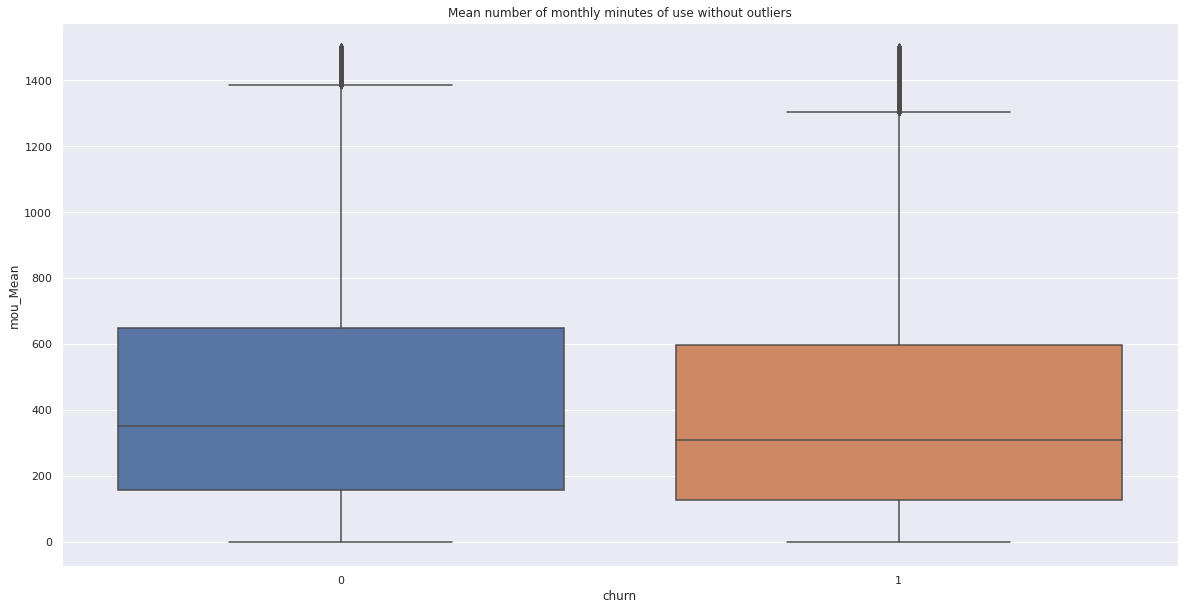

In [69]:
# Selecting mou_Mean < 1500 to have a better visualization
auxh5 = df_raw[df_raw['mou_Mean']<1500]

sns.boxplot(data=auxh5, x='churn', y='mou_Mean').set_title('Mean number of monthly minutes of use without outliers');

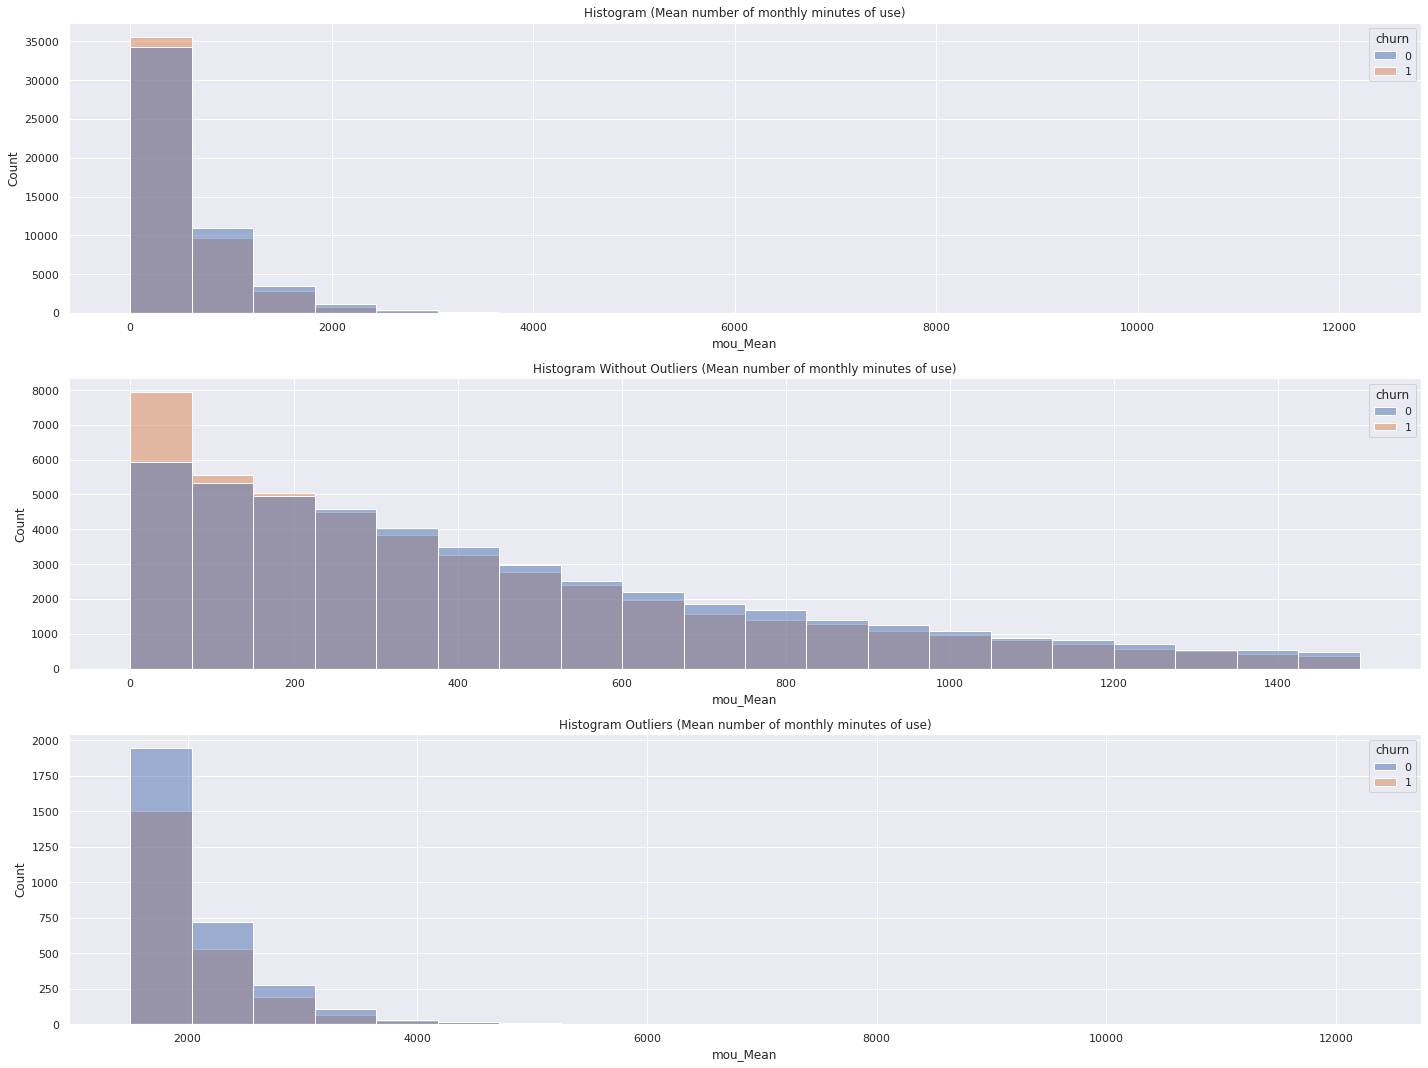

In [70]:
plt.figure(figsize=(20,15))

# Plotting Histogram with all data
plt.subplot(3,1,1)
sns.histplot(data=df_raw, x='mou_Mean', hue='churn', bins=20).set_title('Histogram (Mean number of monthly minutes of use)');

# Plotting Histogram without outliers
plt.subplot(3,1,2)
sns.histplot(data=auxh5, x='mou_Mean', hue='churn', bins=20).set_title('Histogram Without Outliers (Mean number of monthly minutes of use)');

plt.subplot(3,1,3)
aux2h5 = df_raw[df_raw['mou_Mean']>=1500]
sns.histplot(data=aux2h5, x='mou_Mean', hue='churn', bins=20).set_title('Histogram Outliers (Mean number of monthly minutes of use)');

plt.tight_layout()

In [71]:
# Separating dataset by mou_Mean > 355.5 and <= 355.5 (355.5 = median)

mou_Mean_hi = df_raw[df_raw['mou_Mean']>355.5]
mou_Mean_lo = df_raw[df_raw['mou_Mean']<=355.5]

# percentage of churn == 1 for each dataset
perc_mou_Mean_hi = round((mou_Mean_hi['churn'] == 1).sum()/mou_Mean_hi.shape[0], 2)*100
perc_mou_Mean_lo = round((mou_Mean_lo['churn'] == 1).sum()/mou_Mean_lo.shape[0], 3)*100

print(f'{perc_mou_Mean_hi}% of customers churned when the montly average minutes of use was higher than 355.5 minutes')
print(f'{perc_mou_Mean_lo}% of customers churned when the montly average minutes of use was lower than 355.5 minutes')

47.0% of customers churned when the montly average minutes of use was higher than 355.5 minutes
52.1% of customers churned when the montly average minutes of use was lower than 355.5 minutes


## H6. Customers with lower eqpdays (<= 342) are more likely to churn

eqpdays = Number of days (age) of current equipment

**FALSE:** Customers with older equipment are more likely to churn

In [72]:
# Descriptive Statistics
pd.DataFrame(df_raw['eqpdays'].describe()).T

,count,mean,std,min,25%,50%,75%,max
eqpdays,99999.00000,391.93231,256.48219,-5.00000,212.00000,342.00000,530.00000,1823.00000


In [73]:
# Checking negative numbers
df_raw[df_raw['eqpdays']<0].shape

(133, 99)

- Mean and Median are very similar
- Negative values are strange
- There is only 1 missing value
- There are 133 negative values

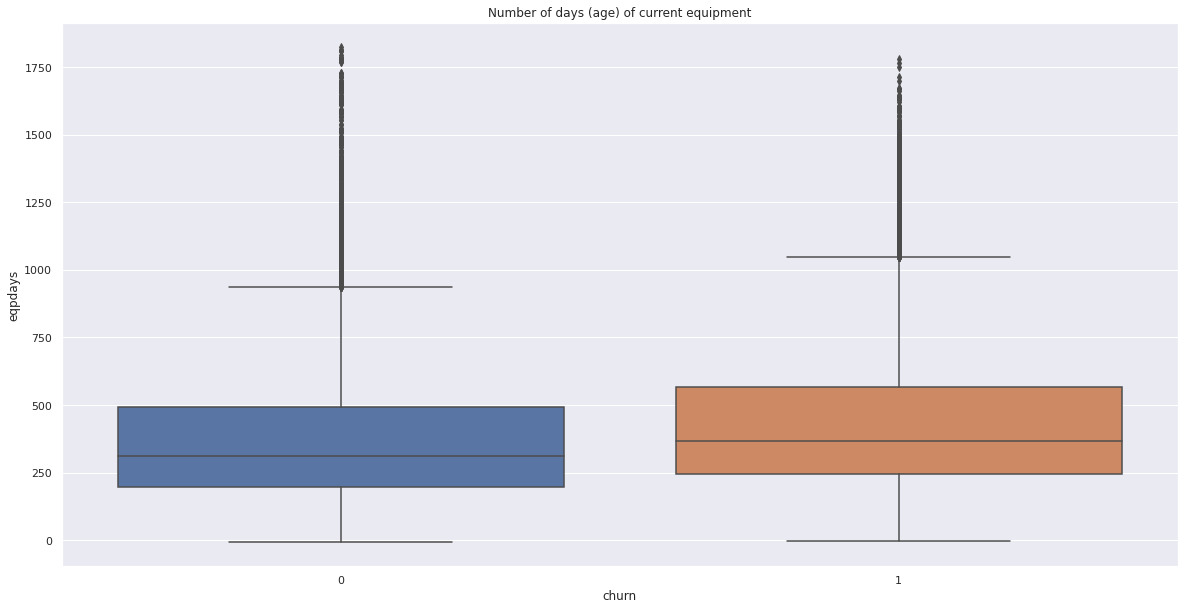

In [74]:
# Plotting Boxplot
sns.boxplot(data=df_raw, x='churn', y='eqpdays').set_title('Number of days (age) of current equipment');

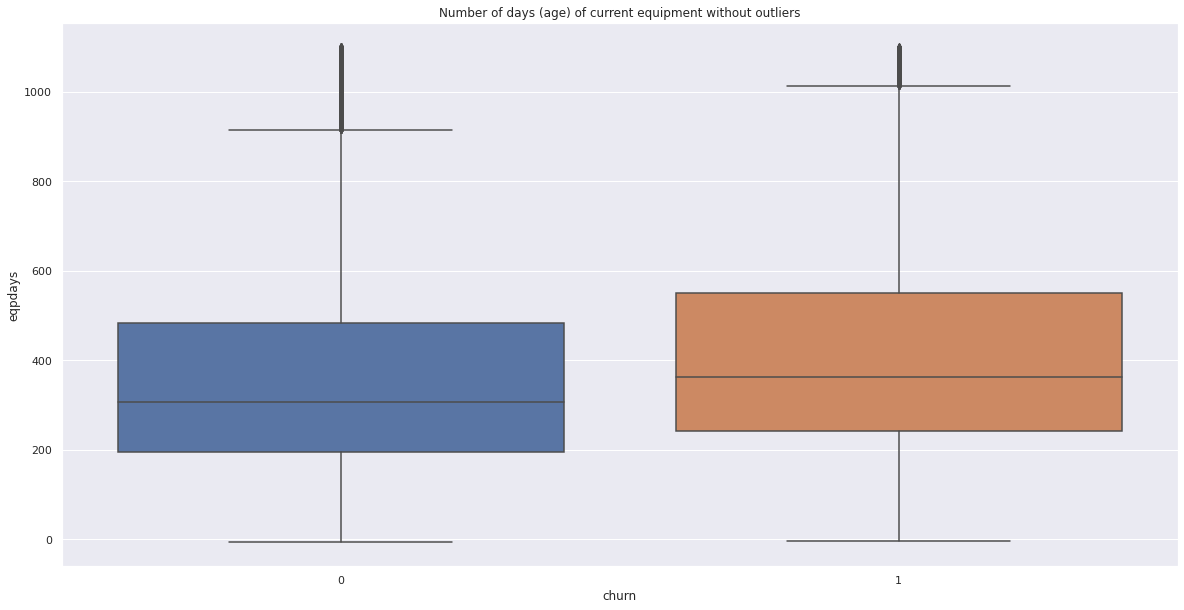

In [75]:
# Selecting eqpdays < 1100 to have a better visualization
auxh6 = df_raw[df_raw['eqpdays']<1100]

sns.boxplot(data=auxh6, x='churn', y='eqpdays').set_title('Number of days (age) of current equipment without outliers');

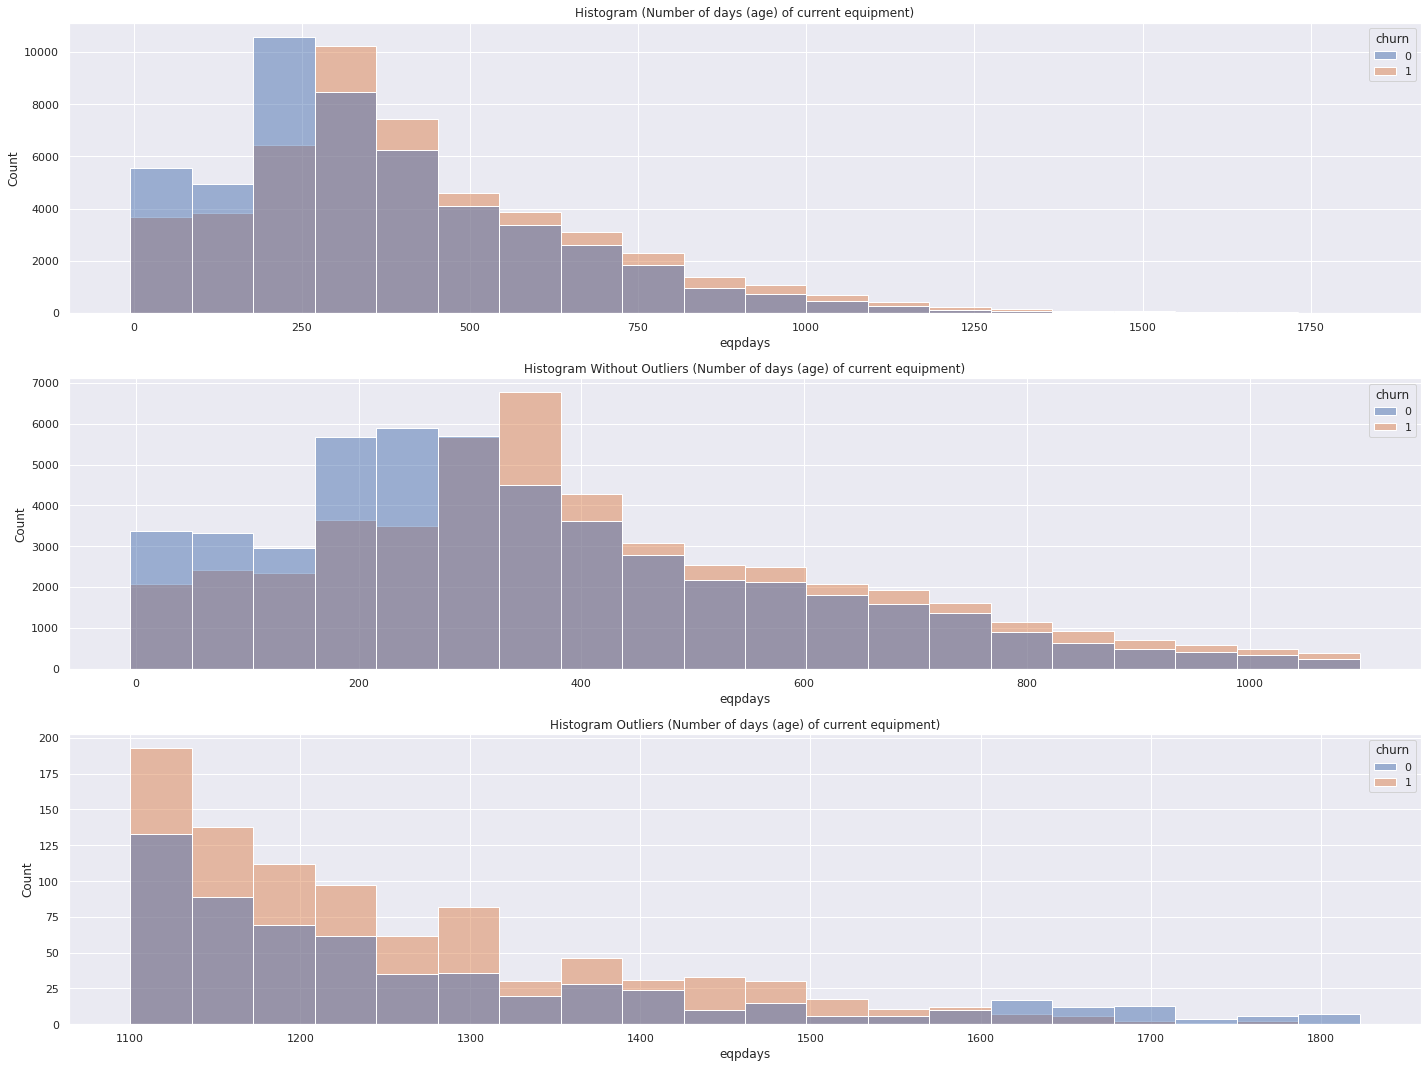

In [76]:
plt.figure(figsize=(20,15))

# Plotting Histogram with all data
plt.subplot(3,1,1)
sns.histplot(data=df_raw, x='eqpdays', hue='churn', bins=20).set_title('Histogram (Number of days (age) of current equipment)');

# Plotting Histogram without outliers
plt.subplot(3,1,2)
sns.histplot(data=auxh6, x='eqpdays', hue='churn', bins=20).set_title('Histogram Without Outliers (Number of days (age) of current equipment)');

plt.subplot(3,1,3)
aux2h6 = df_raw[df_raw['eqpdays']>=1100]
sns.histplot(data=aux2h6, x='eqpdays', hue='churn', bins=20).set_title('Histogram Outliers (Number of days (age) of current equipment)');

plt.tight_layout()

In [77]:
# Separating dataset by eqpdays > 342 and <= 342 (342 = median)

eqpdays_hi = df_raw[df_raw['eqpdays']>342]
eqpdays_lo = df_raw[df_raw['eqpdays']<=342]

# percentage of churn == 1 for each dataset
perc_eqpdays_hi = round((eqpdays_hi['churn'] == 1).sum()/eqpdays_hi.shape[0], 1)*100
perc_eqpdays_lo = round((eqpdays_lo['churn'] == 1).sum()/eqpdays_lo.shape[0], 3)*100

print(f'{perc_eqpdays_hi}% of customers churned when Number of days (age) of current equipment is higher than 342 days')
print(f'{perc_eqpdays_lo}% of customers churned when Number of days (age) of current equipment is lower than 342 days')

60.0% of customers churned when Number of days (age) of current equipment is higher than 342 days
43.8% of customers churned when Number of days (age) of current equipment is lower than 342 days


## H7. Customers with lower months in service are more likely to churn

months = Total number of months in service

**FALSE:** Customers with months in service lower than 10/11 and higher than 35 are more likely to NOT churn. And customers with months in service between 12 and 34 are more likely to churn

In [78]:
# Descriptive Statistics
pd.DataFrame(df_raw['months'].describe()).T

,count,mean,std,min,25%,50%,75%,max
months,100000.00000,18.83399,9.65579,6.00000,11.00000,16.00000,24.00000,61.00000


- Mean and median are similar
- low variance (from 6 to 61)

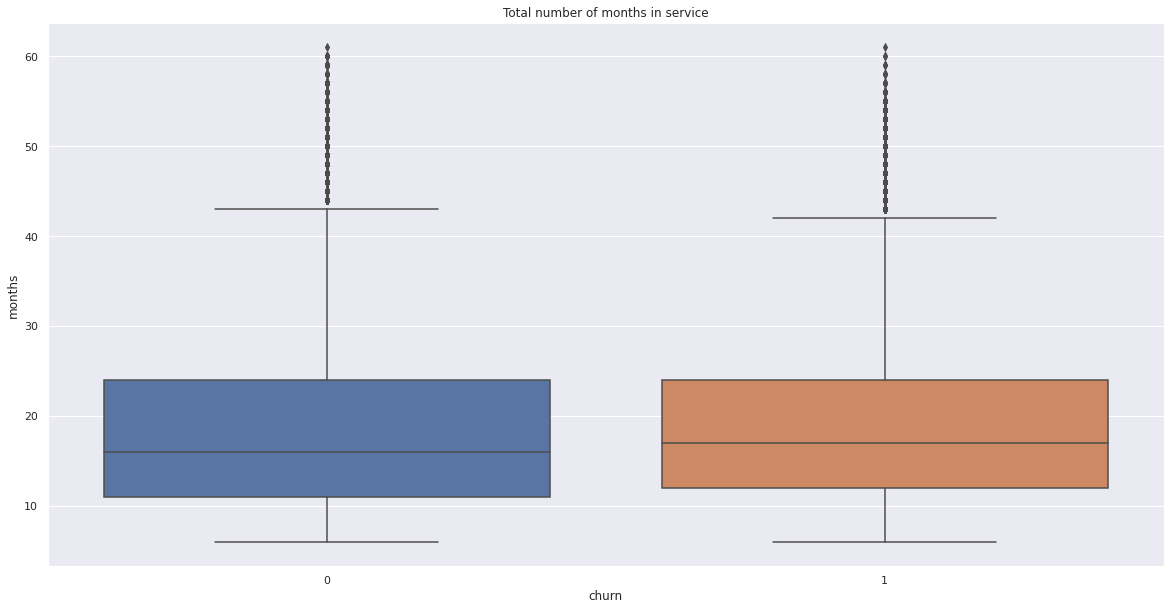

In [79]:
# Plotting Boxplot
sns.boxplot(data=df_raw, x='churn', y='months').set_title('Total number of months in service');

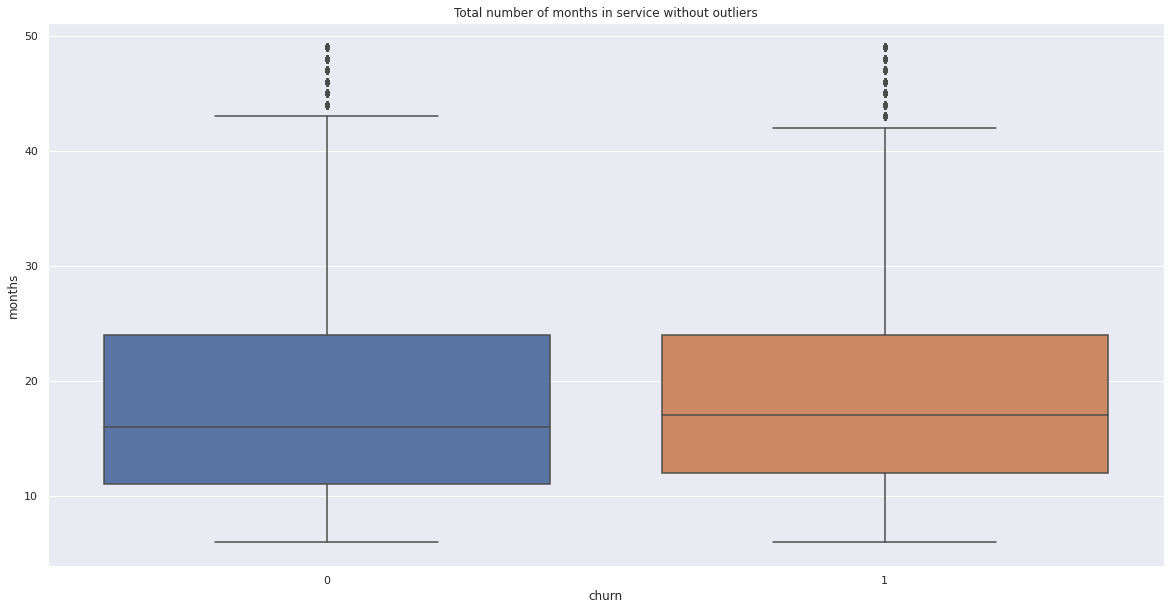

In [80]:
# Selecting months < 50 to have a better visualization
auxh7 = df_raw[df_raw['months']<50]

sns.boxplot(data=auxh7, x='churn', y='months').set_title('Total number of months in service without outliers');

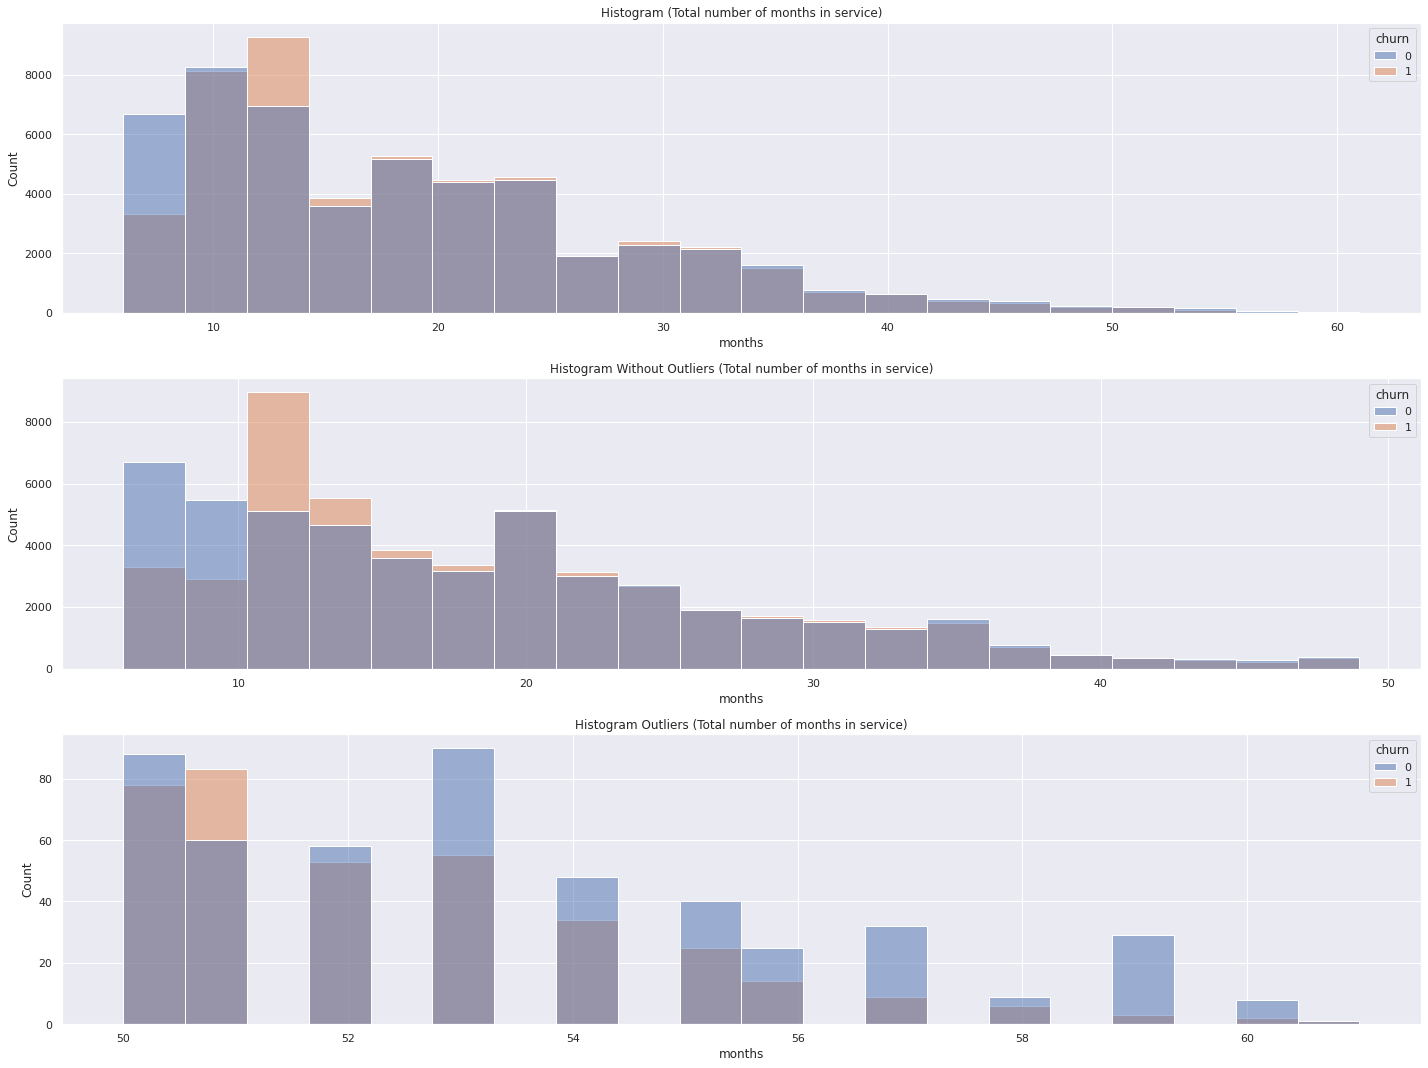

In [81]:
plt.figure(figsize=(20,15))

# Plotting Histogram with all data
plt.subplot(3,1,1)
sns.histplot(data=df_raw, x='months', hue='churn', bins=20).set_title('Histogram (Total number of months in service)');

# Plotting Histogram without outliers
plt.subplot(3,1,2)
sns.histplot(data=auxh7, x='months', hue='churn', bins=20).set_title('Histogram Without Outliers (Total number of months in service)');

plt.subplot(3,1,3)
aux2h7 = df_raw[df_raw['months']>=50]
sns.histplot(data=aux2h7, x='months', hue='churn', bins=20).set_title('Histogram Outliers (Total number of months in service)');

plt.tight_layout()

In [82]:
# Separating dataset by months > 16 and <= 16 (16 = median)

months_hi = df_raw[df_raw['months']>16]
months_lo = df_raw[df_raw['months']<=16]

# percentage of churn == 1 for each dataset
perc_months_hi = round((months_hi['churn'] == 1).sum()/months_hi.shape[0], 1)*100
perc_months_lo = round((months_lo['churn'] == 1).sum()/months_lo.shape[0], 3)*100

print(f'{perc_months_hi}% of customers churned when Total number of months in service are more than 16 months')
print(f'{perc_months_lo}% of customers churned when Total number of months in service are less than 16 months')

50.0% of customers churned when Total number of months in service are more than 16 months
49.1% of customers churned when Total number of months in service are less than 16 months


# PRE-PROCESSING

## Dropping columns with many missing values

In [86]:
df_pp = df_raw.copy()

In [87]:
(df_pp.isna().sum()).sort_values(ascending=False)

numbcars            49366
dwllsize            38308
HHstatin            37923
ownrent             33706
dwlltype            31909
lor                 30190
income              25436
adults              23019
infobase            22079
hnd_webcap          10189
prizm_social_one     7388
avg6mou              2839
avg6qty              2839
avg6rev              2839
ethnic               1732
rv                   1732
forgntvl             1732
creditcd             1732
kid0_2               1732
kid11_15             1732
kid16_17             1732
kid3_5               1732
kid6_10              1732
truck                1732
marital              1732
change_mou            891
change_rev            891
hnd_price             847
mou_Mean              357
ovrmou_Mean           357
ovrrev_Mean           357
datovr_Mean           357
da_Mean               357
vceovr_Mean           357
totmrc_Mean           357
roam_Mean             357
rev_Mean              357
area                   40
dualband    

In [88]:
# Dropping columns with more than 5% of missing values and ID column
df_pp = df_pp.drop(columns=['Customer_ID',
                            'prizm_social_one',
                            'numbcars',
                            'dwllsize',
                            'HHstatin',
                            'ownrent',
                            'dwlltype',
                            'lor',
                            'income',
                            'adults',
                            'infobase',
                            'hnd_webcap'])

## Fillna

In [89]:
# Fillna with Mean values
columns_to_fill = ['avg6qty',
                   'avg6mou',
                   'avg6rev',
                   'change_mou',
                   'change_rev',
                   'hnd_price',
                   'mou_Mean',
                   'ovrmou_Mean',
                   'ovrrev_Mean',
                   'rev_Mean',
                   'roam_Mean',
                   'totmrc_Mean',
                   'datovr_Mean',
                   'da_Mean',
                   'vceovr_Mean']

df_pp.fillna(df_pp[columns_to_fill].mean(), inplace=True)

## Drop NA values

In [90]:
# Columns to dropNA
columns_to_drop = ['ethnic',    
                   'forgntvl',  
                   'kid0_2',    
                   'kid16_17',  
                   'kid3_5',    
                   'kid6_10',   
                   'creditcd',  
                   'kid11_15',  
                   'marital',   
                   'rv',        
                   'truck',     
                   'area',      
                   'refurb_new',
                   'phones',    
                   'models',    
                   'eqpdays',   
                   'dualband']  


df_pp.dropna(subset=columns_to_drop, inplace=True)

## Checking data after dropped data

In [94]:
# checking how many rows were dropped
rows_dropped = df_raw.shape[0] - df_pp.shape[0]

rows_dropped/df_raw.shape[0]
print(f'{rows_dropped} dropped rows ({(rows_dropped/df_raw.shape[0])*100}%)')

1773 dropped rows (1.773%)


In [95]:
# Percentage of churn on original dataset
df_raw['churn'].value_counts(normalize=True)

0   0.50438
1   0.49562
Name: churn, dtype: float64

In [96]:
# Percentage of churn on Pre-Processed dataset
df_pp['churn'].value_counts(normalize=True)

0   0.50414
1   0.49586
Name: churn, dtype: float64

## Pre-process categorical variables

### Frequency Encode

In [97]:
# area - Frequency Encoding
fe_area = df_pp.groupby('area').size() / len(df_pp)
df_pp['area'] = df_pp['area'].map(fe_area)

# crclscod - Frequency Encoding
fe_crclscod = df_pp.groupby('crclscod').size() / len(df_pp)
df_pp['crclscod'] = df_pp['crclscod'].map(fe_crclscod)

# ethnic - Frequency Encoding
fe_ethnic = df_pp.groupby('ethnic').size() / len(df_pp)
df_pp['ethnic'] = df_pp['ethnic'].map(fe_ethnic)

# marital - Frequency Encoding
fe_marital = df_pp.groupby('marital').size() / len(df_pp)
df_pp['marital'] = df_pp['marital'].map(fe_marital)

### Label Encode

In [98]:
# asl_flag - Label_Encode
le_asl_flag = {'Y': 1,
               'N': 0}

df_pp['asl_flag'] = df_pp['asl_flag'].map(le_asl_flag)

# creditcd - Label_Encode
le_creditcd = {'Y': 1,
               'N': 0}

df_pp['creditcd'] = df_pp['creditcd'].map(le_creditcd)

# kid0_2 - Label_Encode
le_kid0_2 = {'Y': 1,
             'U': 0}

df_pp['kid0_2'] = df_pp['kid0_2'].map(le_kid0_2)

# kid11_15 - Label_Encode
le_kid11_15 = {'Y': 1,
               'U': 0}

df_pp['kid11_15'] = df_pp['kid11_15'].map(le_kid11_15)

# kid16_17 - Label_Encode
le_kid16_17 = {'Y': 1,
               'U': 0}

df_pp['kid16_17'] = df_pp['kid16_17'].map(le_kid16_17)

# kid3_5 - Label_Encode
le_kid3_5 = {'Y': 1,
             'U': 0}

df_pp['kid3_5'] = df_pp['kid3_5'].map(le_kid3_5)

# kid6_10 - Label_Encode
le_kid6_10 = {'Y': 1,
              'U': 0}

df_pp['kid6_10'] = df_pp['kid6_10'].map(le_kid6_10)

# refurb_new - Label_Encode
le_refurb_new = {'N': 1,
                 'R': 0}

df_pp['refurb_new'] = df_pp['refurb_new'].map(le_refurb_new)

### One Hot Encode

In [99]:
# dualband - One Hot Encode
ohc_dualband = pp.OneHotEncoder()
df_pp['dualband_N'] = ohc_dualband.fit_transform(df_pp[['dualband']]).toarray()[:,0]
df_pp['dualband_T'] = ohc_dualband.fit_transform(df_pp[['dualband']]).toarray()[:,1]
df_pp['dualband_U'] = ohc_dualband.fit_transform(df_pp[['dualband']]).toarray()[:,2]
df_pp['dualband_Y'] = ohc_dualband.fit_transform(df_pp[['dualband']]).toarray()[:,3]
df_pp.drop(columns='dualband', inplace=True)

# new_cell - One Hot Encode
ohc_new_cell = pp.OneHotEncoder()
df_pp['new_cell_N'] = ohc_new_cell.fit_transform(df_pp[['new_cell']]).toarray()[:,0]
df_pp['new_cell_U'] = ohc_new_cell.fit_transform(df_pp[['new_cell']]).toarray()[:,1]
df_pp['new_cell_Y'] = ohc_new_cell.fit_transform(df_pp[['new_cell']]).toarray()[:,2]
df_pp.drop(columns='new_cell', inplace=True)


## Saving pre-processed dataset

In [18]:
df_pp.to_csv('../data/df_pp.csv', sep=';', index_label=False)

# TRAIN AND TEST SPLIT

In [7]:
# Loading pre-processed dataset
df_pp = pd.read_csv('../data/df_pp.csv', sep=';')

In [8]:
 # Spliting Data into Train and Test
X = df_pp.drop('churn', axis=1)
y = df_pp['churn'].copy()

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# MACHINE LEARNING

In [6]:
# Loading Pre-processed dataset
df_cv = pd.read_csv('../data/df_pp.csv', sep=';')

# Dataset for Cross-validation
x_cv = df_cv.drop(columns=['churn'])
y_cv = df_cv['churn']

## Baseline for Comparison - Dummy Classifier

In [104]:
# Instantiate Dummy classifier - always predict 1 = churn
dummy_model = DummyClassifier(strategy='constant', constant=1)

# Fit model
dummy_model.fit(x_train, y_train)

# Prediction
y_hat_dummy = dummy_model.predict(x_test)

# Model Performance on test dataset
performance = pd.DataFrame(['Dummy Classifier',
                             metrics.accuracy_score(y_test, y_hat_dummy),
                             metrics.precision_score(y_test, y_hat_dummy),
                             metrics.recall_score(y_test, y_hat_dummy),
                             metrics.roc_auc_score(y_test, y_hat_dummy)]).T

performance.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'ROC-AUC']

performance

,Model,Accuracy,Precision,Recall,ROC-AUC
0,Dummy Classifier,0.49866,0.49866,1.00000,0.50000


## Decision Tree

In [105]:
# Instantiate Model
dtc = DecisionTreeClassifier(criterion='entropy',
                             max_depth=4,
                             min_samples_split=0.05,
                             random_state=42)

# Fit model
dtc.fit(x_train, y_train)

# Prediction
y_hat = dtc.predict(x_test)
 
# Model Performance on test dataset
performance = pd.DataFrame(['Decision Tree Classifier',
                                metrics.accuracy_score(y_test, y_hat),
                                metrics.precision_score(y_test, y_hat),
                                metrics.recall_score(y_test, y_hat),
                                metrics.roc_auc_score(y_test, y_hat)]).T

performance.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'ROC-AUC']

performance

,Model,Accuracy,Precision,Recall,ROC-AUC
0,Decision Tree Classifier,0.58855,0.56506,0.75951,0.58901


### Cross-Validation

In [106]:
# Cross-validation Metrics Performance

# Accuracy
dtc_cv = cross_val_score(dtc, x_cv, y_cv, cv=10, scoring='accuracy')
dtc_cv_acc = pd.DataFrame(['Accuracy', (dtc_cv.mean()*100).round(3), (dtc_cv.std()*100)]).T

# Precision
dtc_cv = cross_val_score(dtc, x_cv, y_cv, cv=10, scoring='precision')
dtc_cv_prec = pd.DataFrame(['Precision', (dtc_cv.mean()*100).round(3), (dtc_cv.std()*100)]).T

# Recall
dtc_cv = cross_val_score(dtc, x_cv, y_cv, cv=10, scoring='recall')
dtc_cv_recall = pd.DataFrame(['Recall', (dtc_cv.mean()*100).round(3), (dtc_cv.std()*100)]).T


# ROC-AUC
dtc_cv = cross_val_score(dtc, x_cv, y_cv, cv=10, scoring='roc_auc')
dtc_cv_roc = pd.DataFrame(['ROC-AUC', (dtc_cv.mean()*100).round(3), (dtc_cv.std()*100)]).T

# Cross-Validation Performance
dtc_cv_performance = pd.concat([dtc_cv_acc,
                                dtc_cv_prec,
                                dtc_cv_recall,
                                dtc_cv_roc])

dtc_cv_performance.columns = ['Metric', 'Mean', 'std']
dtc_cv_performance

,Metric,Mean,std
0,Accuracy,57.17700,4.75208
0,Precision,56.93600,7.21809
0,Recall,72.37400,15.38864
0,ROC-AUC,58.00700,5.66791


# HYPERPARAMETER FINE TUNNING

## Random Search

In [107]:
# Setting parameters to search
params = {
    'max_depth': [2, 3, 4, 5, 6],
    'min_samples_leaf': [0.02, 0.03, 0.05, 0.08, 0.1],
    'criterion': ["gini", "entropy"]}

# Instantiate Random Search
random_search = RandomizedSearchCV(estimator=dtc, 
                                   param_distributions=params, 
                                   cv=10, n_jobs=-1,
                                   verbose=1,
                                   scoring = "precision",
                                   random_state=42)

# Search Parameters
results = random_search.fit(x_train, y_train)

# Best model parameters
print(f'\nBest Parameters:\n{results.best_params_}')

Fitting 10 folds for each of 10 candidates, totalling 100 fits

Best Parameters:
{'min_samples_leaf': 0.02, 'max_depth': 6, 'criterion': 'entropy'}


## Final Model

In [9]:
# Instantiate Model
dtc_final = DecisionTreeClassifier(criterion='entropy',
                                   max_depth=6,
                                   min_samples_leaf=0.02,
                                   random_state=42)

# Fit model
dtc_final.fit(x_train, y_train)

# Prediction
y_hat_final = dtc_final.predict(x_test)
 
# Model Performance
performance = pd.DataFrame(['Decision Tree Classifier',
                             metrics.accuracy_score(y_test, y_hat_final),
                             metrics.precision_score(y_test, y_hat_final),
                             metrics.recall_score(y_test, y_hat_final),
                             metrics.roc_auc_score(y_test, y_hat_final)]).T

performance.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'ROC-AUC']

performance

,Model,Accuracy,Precision,Recall,ROC-AUC
0,Decision Tree Classifier,0.59076,0.57898,0.65723,0.59093


In [10]:
# Cross-validation Metrics Performance

# Accuracy
dtc_cv = cross_val_score(dtc_final, x_cv, y_cv, cv=10, scoring='accuracy')
dtc_cv_acc = pd.DataFrame(['Accuracy', (dtc_cv.mean()*100).round(3), (dtc_cv.std()*100)]).T

# Precision
dtc_cv = cross_val_score(dtc_final, x_cv, y_cv, cv=10, scoring='precision')
dtc_cv_prec = pd.DataFrame(['Precision', (dtc_cv.mean()*100).round(3), (dtc_cv.std()*100)]).T

# Recall
dtc_cv = cross_val_score(dtc_final, x_cv, y_cv, cv=10, scoring='recall')
dtc_cv_recall = pd.DataFrame(['Recall', (dtc_cv.mean()*100).round(3), (dtc_cv.std()*100)]).T


# ROC-AUC
dtc_cv = cross_val_score(dtc_final, x_cv, y_cv, cv=10, scoring='roc_auc')
dtc_cv_roc = pd.DataFrame(['ROC-AUC', (dtc_cv.mean()*100).round(3), (dtc_cv.std()*100)]).T

# Cross-Validation Performance
dtc_cv_performance = pd.concat([dtc_cv_acc,
                                dtc_cv_prec,
                                dtc_cv_recall,
                                dtc_cv_roc])

dtc_cv_performance.columns = ['Metric', 'Mean', 'std']
dtc_cv_performance

,Metric,Mean,std
0,Accuracy,57.07800,3.79043
0,Precision,57.25800,6.43796
0,Recall,62.48300,14.70476
0,ROC-AUC,59.91600,5.16441


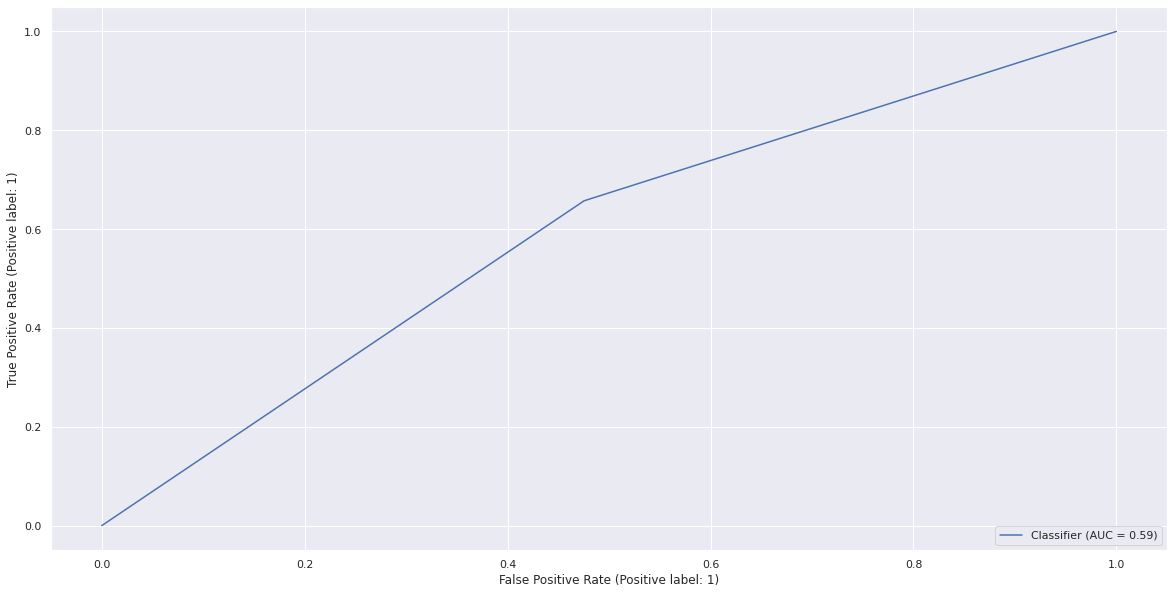

In [12]:
# plotting Roc Curve
metrics.RocCurveDisplay.from_predictions(y_test, y_hat_final);

# FEATURES OF CUSTOMERS WITH HIGHER PROPENSITY TO CHURN

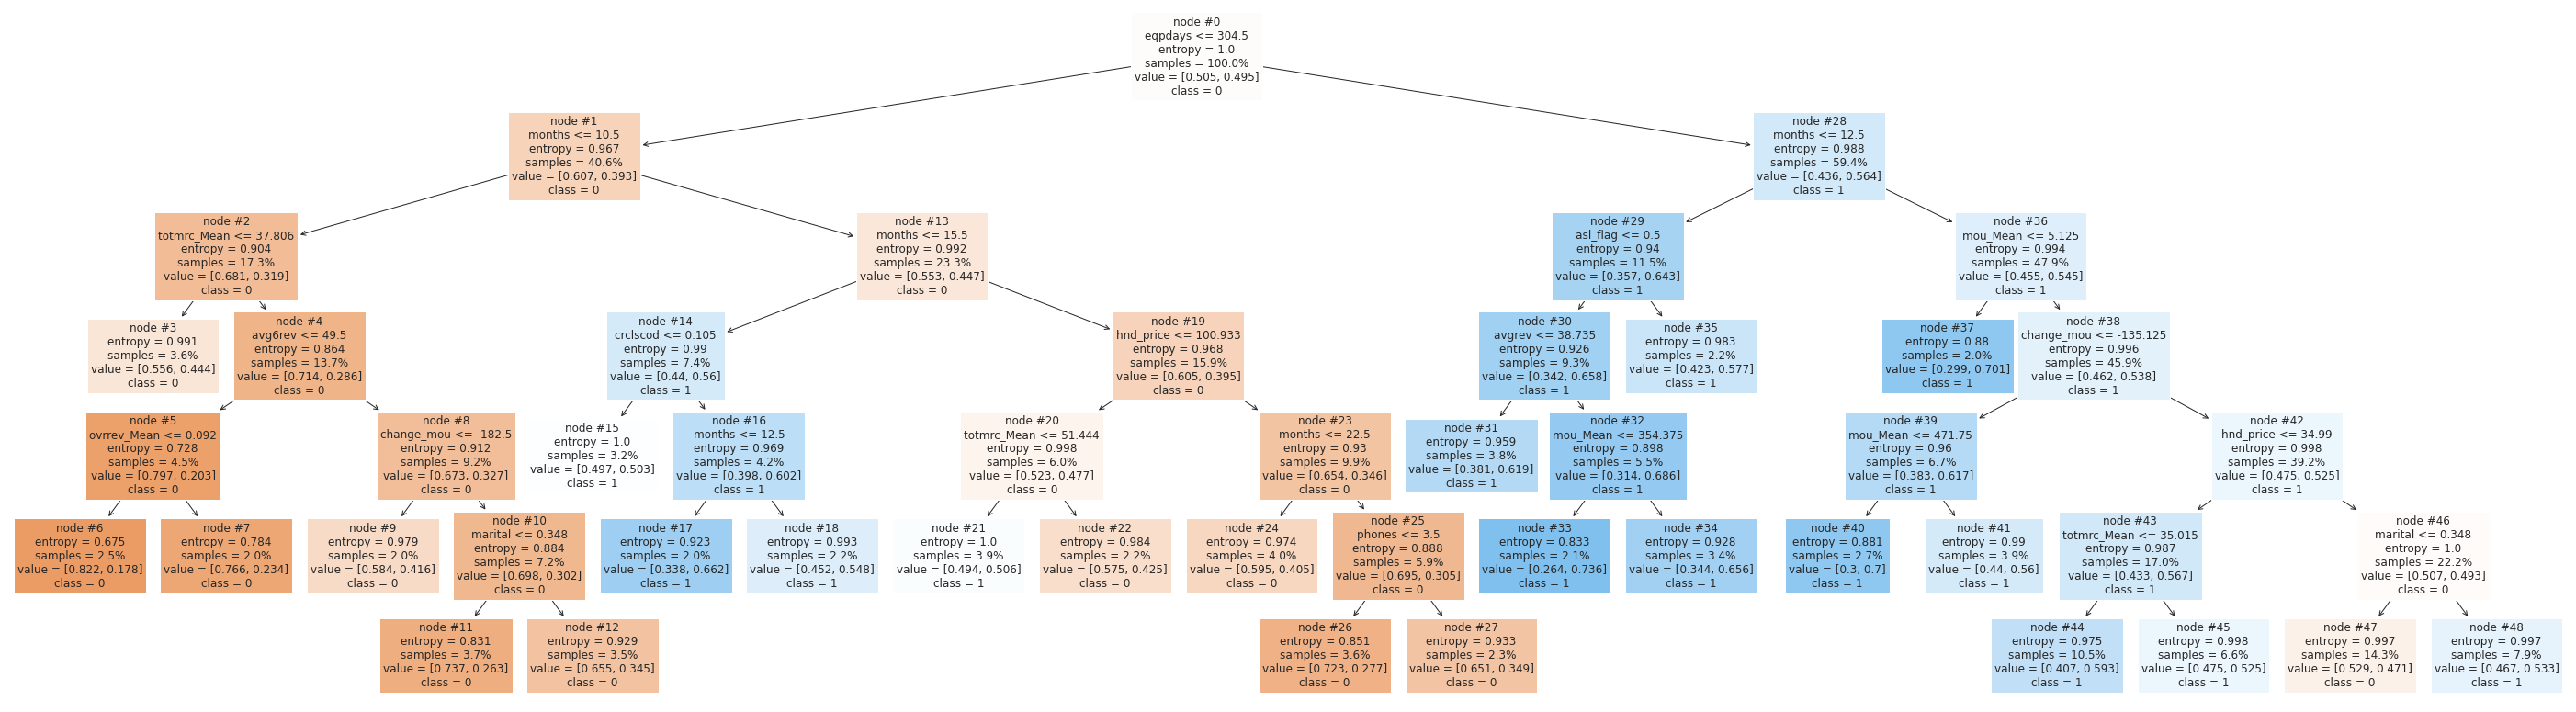

In [112]:
plt.figure(figsize=(50,14))
tree.plot_tree(dtc_final,
               feature_names=x_train.columns,
               class_names=['0', '1'],
               filled=True,
               proportion=True,
               node_ids=True,
               fontsize=12);

- **Node 33** - The customer with the highest probability (73.6%) to churn:
    - Number of days (age) of current equipment >304.5
    - Total number of months in service <= 12.5
    - Account spending limit < 0.5    
    - Average monthly revenue over the life of the customer > 38.735
    - Mean number of monthly minutes of use <= 354.375    
    
    
- **Node 37** - 70.1% propability to churn:
    - Number of days (age) of current equipment >304.5
    - Total number of months in service > 12.5
    - Mean number of monthly minutes of use <= 5.125


- **Node 40** - 70% probability to churn:
    - Number of days (age) of current equipment >304.5
    - Total number of months in service > 12.5
    - Mean number of monthly minutes of use > 5.125
    - Percentage change in monthly minutes of use vs previous three month average <= -135.125
    - Mean number of monthly minutes of use <= 471.75
    

- **eqpdays:** Number of days (age) of current equipment
- **months:** Total number of months in service
- **asl_flag:** Account spending limit
- **avgrev:** Average monthly revenue over the life of the customer
- **mou_Mean:** Mean number of monthly minutes of use
- **change_mou:** Percentage change in monthly minutes of use vs previous three month average







# BUSINESS RESULTS

- The metric that I am going to look to evaluate the model is **Precision**.
- If we compare the dummy classifier (that always predict churn) with the decision tree, we can see that the decision tree has precision of 57.26% and the dummy classifier has 49.87%.
- The decision tree model has 7.39% increase in precision.
- It might not seem much, but I am going to make some scenarios to ilustrate it better.

## Scenarios

### Business assumptions

In [153]:
# Descriptive Statistics - avg3rev ( Average monthly revenue over the previous three months)
pd.DataFrame(df_raw['avg3rev'].describe()).T

,count,mean,std,min,25%,50%,75%,max
avg3rev,100000.00000,59.19333,46.69543,1.00000,33.00000,48.00000,71.00000,1593.00000


- **1.** The company wants to identify customers that are going to churn in the near future so that they can take action to try to retain the customer.
- **2.** The strategy to retain the customer is to give BRL 20,00 discount on their plan.
- **3.** So the cost is BRL 20,00 for each customer that the company approach.
- **4.** If the customer don't churn, the company prevented a loss, that is, the revenue that the customer would give to the company
- **5.** To simplify, I am going to assume that the company would lose BRL 48,00 (The median of the average monthly revenue over the previous three months of all customers), if the customer churns.
- **6.** I am going to calculate the cost/benefit on test dataset.

### Baseline Performance

In [297]:
# Scenarios
convertion_rate = [1.0, 0.8, 0.6, 0.4, 0.2]

# Baseline precision
precision = 0.49866

baseline_results = pd.DataFrame(columns=[])

for scenario in convertion_rate:
    aux = prevented_loss(conv_rate=scenario, precision=precision, y_hat=y_hat_dummy, model_name='Dummy Classifier')
    baseline_results = pd.concat([baseline_results, aux])
    
baseline_results

,convertion_rate_%,prevented_loss
Dummy Classifier,1.00000,115980.00000
Dummy Classifier,0.80000,-25092.00000
Dummy Classifier,0.60000,-166164.00000
Dummy Classifier,0.40000,-307236.00000
Dummy Classifier,0.20000,-448308.00000


### Decision Tree Performance

In [280]:
# Scenarios
convertion_rate = [1.0, 0.8, 0.6, 0.4, 0.2]

# Decision Tree precision
precision = 0.57258

dt_results = pd.DataFrame(columns=[])

for scenario in convertion_rate:
    aux = prevented_loss(conv_rate=scenario, precision=precision, y_hat=y_hat_final, model_name='Decision Tree')
    dt_results = pd.concat([dt_results, aux])
    
dt_results

,convertion_rate_%,prevented_loss
Decision Tree,1.00000,476284.00000
Decision Tree,0.80000,314303.00000
Decision Tree,0.60000,152322.00000
Decision Tree,0.40000,-9658.00000
Decision Tree,0.20000,-171639.00000


### Results

In [292]:
print('Difference Between Baseline model and Decision Tree')
for i in range(dt_results.shape[0]):
    print(dt_results['prevented_loss'][i] - baseline_results['prevented_loss'][i])

Difference Between Baseline model and Decision Tree
360304.0
339395.0
318486.0
297578.0
276669.0
